---
---

# Fashion AI
The objective is to create a generative search system capable of searching a plethora of fashion product descriptions to find and recommend appropriate choices against a user query.

---
---

## Table of Content

* [Install and Import the required libraries](#import)
* [Layer 1 : Build Vector store](#layer1)
    * [1.1 Explore and prepare the data](#layer1_explore)
    * [1.2 Generate and Store Embeddings using SentenceTranformer and ChromaDB](#layer1_chroma)
* [Layer 2 : Search & Rank Layer](#layer2)
    * [2.1 Implement query from either cache or main collection](#layer2_query)
    * [2.2 Re-Ranking with a Cross Encoder](#layer2_reranking)
    * [2.3 Semantic Search with Re-ranking](#layer2_all)
* [Layer 3 : Generative Search - Bringing it All !](#layer3)
* [Experimenting with queries](#exp)
    * [Query 1 : "Maroon blazer for casual occasion from Van Heusen"](#exp_1)
    * [Query 2 : "White anarkali kurta with a rating of more than 4"](#exp_2)
    * [Query 3 : "Denim jacket with atleast 4 pockets, a rating of 4 and price less than 3000"](#exp_3)
* [Playground](#playground)

---
---

<a id='import'></a>
## <p style="color: #ffd700; background-color: #006400;"> Install and Import the required Libraries

In [1]:
# Install all the required libraries
!pip install -U -q openai chromadb sentence-transformers einops

In [2]:
# Import the necessary libraries
from pathlib import Path
import pandas as pd
import ast
from tqdm import tqdm
import re
from IPython.display import Image, display

# Import open ai and chroma libraries
import openai
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

---
---
<a id='layer1'></a>
## <p style="color: #ffd700; background-color: #006400;"> Layer 1 : Build Vector store </p>

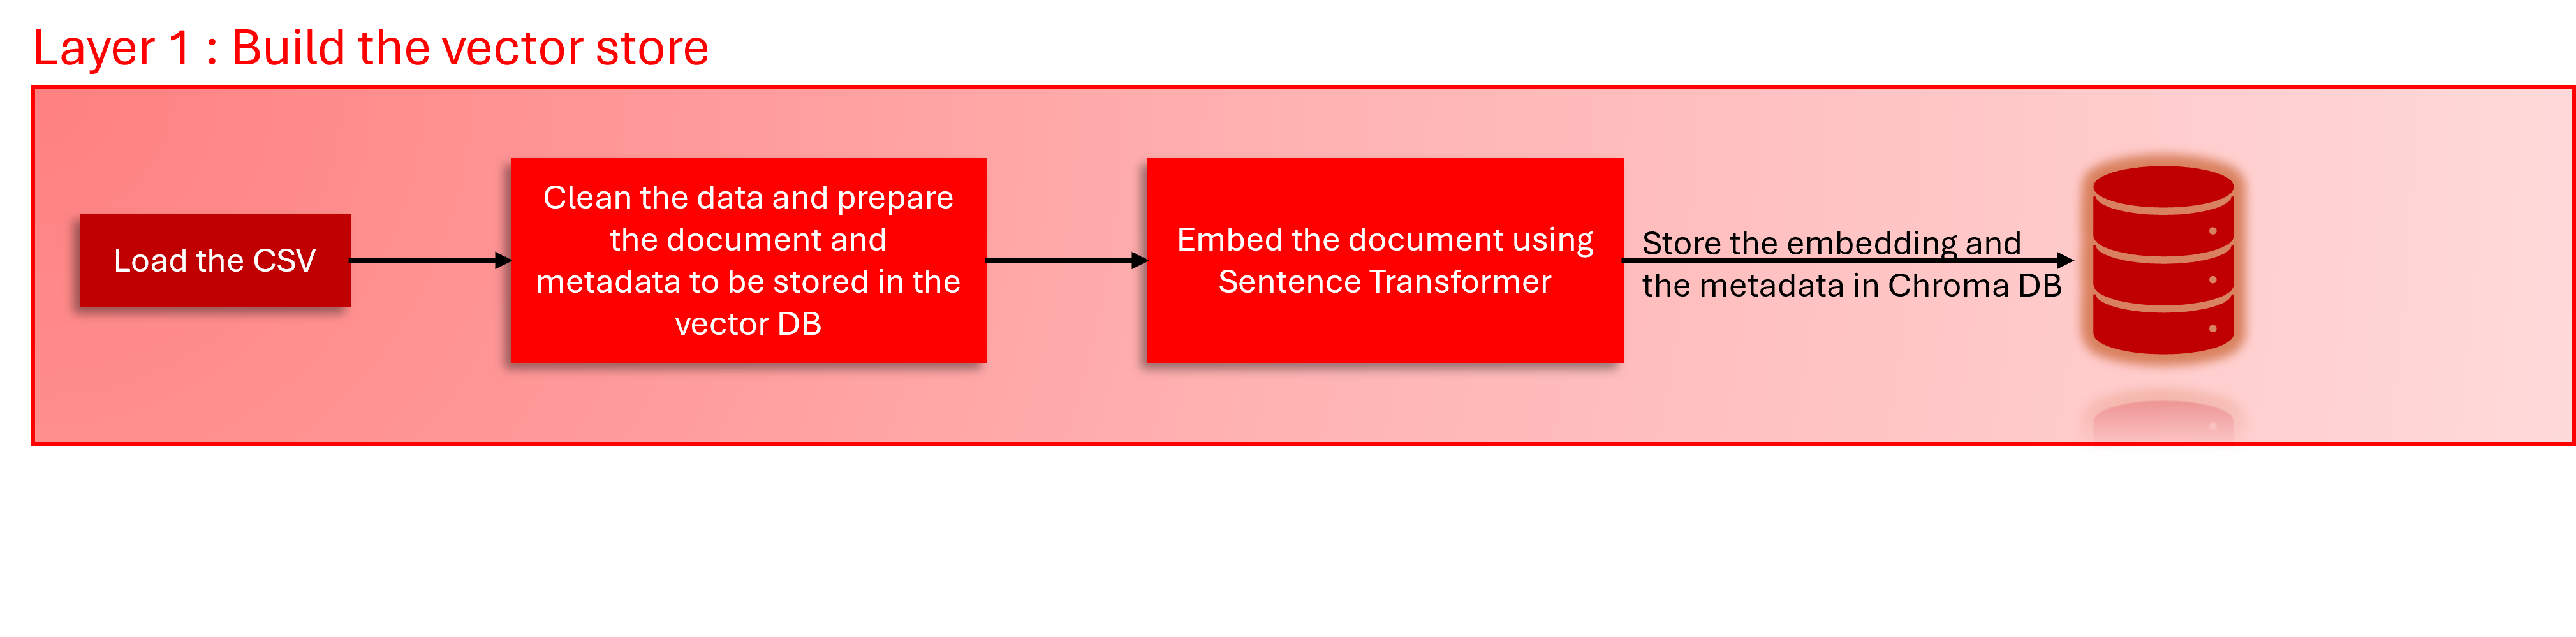

<a id='layer1_explore'></a>
### <p style="color: #333333; background-color: #ffc0cb;"> 1.1 Explore and prepare the data </p>

> Let us explore the data

In [3]:
# Define the path to the Fashion Dataset CSV file.
data_path = "dataset\\Fashion Dataset v2.csv"

# Read the CSV file into a pandas DataFrame.
fashion_df = pd.read_csv(data_path)

# Display the first few rows of the DataFrame to inspect the data.
fashion_df.head()

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products  price     colour      brand  \
0               Kurta, Palazzos, Dupatta   5099      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta   5899     Orange    InWeave   
2               Kurta, Trousers, Dupatta   4899  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta   3699        Red       Nayo   
4                                  Kurta   1350      Black      AHIKA   

                                                 img  ratingCount  avg_rating  \
0  http://assets.myntassets.com/assets/images/170...       4522.0    4.418399   
1  http://assets.myntassets.com/assets/images/165...       1081.0    4.119334   
2  http://assets.myntassets.com/assets/images/163...       1752.0    4.161530   
3  http://assets.myntassets.com/assets/images/147...       4113.0    4.088986   
4  http://assets.myntassets.com/assets/images/110...      21274.0    3.978377   

                                         description  \
0  Black printed Kurta with Palazzos with dupatta...   
1  Orange solid Kurta with Palazzos with dupatta<...   
2  Navy blue embroidered Kurta with Trousers with...   
3  Red printed kurta with trouser and dupatta<br>...   
4  Black and green printed straight kurta, has a ...   

                                        p_attributes  
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
4  {'Body Shape ID': '424', 'Body or Garment Size...

We can ignore `'img'` column since it contains _URI_ for the product image which is already available in _'dataset/images'_ folder with the file name given in `'p_id'` column.

In [4]:
# Remove the 'img' column from the fashion DataFrame to exclude image data.
fashion_df = fashion_df.drop(columns=['img'])

# Display the first few rows of the modified DataFrame.
fashion_df.head()

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products  price     colour      brand  \
0               Kurta, Palazzos, Dupatta   5099      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta   5899     Orange    InWeave   
2               Kurta, Trousers, Dupatta   4899  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta   3699        Red       Nayo   
4                                  Kurta   1350      Black      AHIKA   

   ratingCount  avg_rating                                        description  \
0       4522.0    4.418399  Black printed Kurta with Palazzos with dupatta...   
1       1081.0    4.119334  Orange solid Kurta with Palazzos with dupatta<...   
2       1752.0    4.161530  Navy blue embroidered Kurta with Trousers with...   
3       4113.0    4.088986  Red printed kurta with trouser and dupatta<br>...   
4      21274.0    3.978377  Black and green printed straight kurta, has a ...   

                                        p_attributes  
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
4  {'Body Shape ID': '424', 'Body or Garment Size...

> We can see that the description cloumn is in a HTML format. Let's clean that up.

In [5]:
# Peek into the description of the first item in the fashion DataFrame.
fashion_df.description[0]

"Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  </b> <ul> <li> Ethnic motifs printed </li> <li> Anarkali shape </li> <li> Regular style </li> <li> Mandarin collar,  three-quarter regular sleeves </li> <li> Calf length with flared hem </li> <li> Viscose rayon machine weave fabric </li> </ul> <br> <b> Palazzos design:  </b> <ul> <li> Printed Palazzos </li> <li> Elasticated waistband </li> <li> Slip-on closure </li> </ul>Dupatta Length 2.43 meters Width:&nbsp;88 cm<br>The model (height 5'8) is wearing a size S100% Rayon<br>Machine wash"

In [6]:
# Define a function to remove HTML tags from the input string.
def remove_html_tags(html_string):
    # Regular expression pattern to match text between HTML tags.
    pattern = re.compile(r'<.*?>')

    # Use regular expression to replace HTML tags with spaces.
    python_string = re.sub(pattern, ' ', html_string)
    
    # Split the string by spaces, remove empty strings, and join them back.
    python_string = python_string.split(' ')
    python_string = list(filter(lambda x: x != "", python_string))
    python_string = " ".join(python_string)
    
    # Return the cleaned Python string.
    return python_string

In [7]:
# An example clean up
remove_html_tags(fashion_df.description[0])

"Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs printed Anarkali shape Regular style Mandarin collar, three-quarter regular sleeves Calf length with flared hem Viscose rayon machine weave fabric Palazzos design: Printed Palazzos Elasticated waistband Slip-on closure Dupatta Length 2.43 meters Width:&nbsp;88 cm The model (height 5'8) is wearing a size S100% Rayon Machine wash"

> Let us apply the **HTML** cleanup on the `'description'` column

In [8]:
# Apply the remove_html_tags function to clean HTML tags from the 'description' column
# and create a new column 'cleaned_desc' in the fashion DataFrame.
fashion_df['cleaned_desc'] = fashion_df['description'].apply(lambda x: remove_html_tags(x))

# Display the first few rows of the modified DataFrame.
fashion_df.head()

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products  price     colour      brand  \
0               Kurta, Palazzos, Dupatta   5099      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta   5899     Orange    InWeave   
2               Kurta, Trousers, Dupatta   4899  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta   3699        Red       Nayo   
4                                  Kurta   1350      Black      AHIKA   

   ratingCount  avg_rating                                        description  \
0       4522.0    4.418399  Black printed Kurta with Palazzos with dupatta...   
1       1081.0    4.119334  Orange solid Kurta with Palazzos with dupatta<...   
2       1752.0    4.161530  Navy blue embroidered Kurta with Trousers with...   
3       4113.0    4.088986  Red printed kurta with trouser and dupatta<br>...   
4      21274.0    3.978377  Black and green printed straight kurta, has a ...   

                                        p_attributes  \
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...   
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...   
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...   
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...   
4  {'Body Shape ID': '424', 'Body or Garment Size...   

                                        cleaned_desc  
0  Black printed Kurta with Palazzos with dupatta...  
1  Orange solid Kurta with Palazzos with dupatta ...  
2  Navy blue embroidered Kurta with Trousers with...  
3  Red printed kurta with trouser and dupatta Kur...  
4  Black and green printed straight kurta, has a ...

#### Product portfolio

- The product information is currently fragmented across various columns, hindering comprehensive keyword searches.
- Since our query focuses solely on documents, this fragmentation poses limitations.
<br>

- There are two solutions:
    - *Option 1*: Centralize all the product details as metadata. Develop a chatbot to extract metadata values, facilitating precise filtering. Utilize the filtered results to construct a RAG model.
    - *Option 2*: Compile a cohesive document called as 'portfolio' incorporating all product details. Load this document entirely into the document section of the vector DB. This ensures vector DB is aware of additional keywords used in user queries.
    
> For the present task, I opted for option 2 for enhanced efficiency.

In [9]:
# Define a function to generate a portfolio string for a given product.
# Exclude 'ratingCount' and 'p_id' from the portfolio as they are not significant for search queries.
def product_portfolio(product):
    # Create a document string with product details, formatting with placeholders.
    product_document = f"""Name : {product['name']}\n Category : {product['products']}\n Price : {product['price']}\n Color : {product['colour']}\n Brand : {product['brand']}\n Rating : {f"{product['avg_rating']:.2f}"}\n Description : {product['cleaned_desc']}\n Attributes : {product['p_attributes']}"""
    return product_document

In [10]:
# An example product portfolio
product_portfolio(fashion_df.iloc[234])

"Name : Libas Women Grey Self Design Chanderi Silk Kurta with Skirt & With Dupatta\n Category : Kurta, Skirt, Dupatta\n Price : 7999\n Color : Grey\n Brand : Libas\n Rating : 4.50\n Description : Grey self design Kurta with Skirt with dupatta&nbsp; Kurta design: Woven design self design Straight shape Regular style Sweetheart neck, three-quarter regular sleeves Gotta patti detail Above knee length with flared hem Chanderi silk knitted and woven fabric Skirt design: Printed Skirt Partially elasticated waistband Drawstring closure Top fabric: Chanderi Silk Bottom fabric: Pure Silk Dupatta fabric: Pure Silk Machine washDupatta length: 2 metres (approx.) The model (height 5'8) is wearing a size S\n Attributes : {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Drawstring', 'Bottom Fabric': 'Pure Silk', 'Bottom Pattern': 'Printed', 'Bottom Type': 'Skirt', 'Character': 'NA', 'Dupatta': 'With Dupatta', 'Dupatta Border':

> Let us create the portfolio for each document.

In [11]:
# Create a portfolio for each product in the fashion DataFrame using the product_portfolio function.
fashion_df['portfolio'] = fashion_df.apply(product_portfolio, axis=1)

# Calculate the length of each product portfolio and store it in a new column 'portfolio_len'.
fashion_df['portfolio_len'] = fashion_df['portfolio'].apply(lambda x: len(x))

# Display the first few rows of the modified DataFrame.
fashion_df.head()

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products  price     colour      brand  \
0               Kurta, Palazzos, Dupatta   5099      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta   5899     Orange    InWeave   
2               Kurta, Trousers, Dupatta   4899  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta   3699        Red       Nayo   
4                                  Kurta   1350      Black      AHIKA   

   ratingCount  avg_rating                                        description  \
0       4522.0    4.418399  Black printed Kurta with Palazzos with dupatta...   
1       1081.0    4.119334  Orange solid Kurta with Palazzos with dupatta<...   
2       1752.0    4.161530  Navy blue embroidered Kurta with Trousers with...   
3       4113.0    4.088986  Red printed kurta with trouser and dupatta<br>...   
4      21274.0    3.978377  Black and green printed straight kurta, has a ...   

                                        p_attributes  \
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...   
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...   
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...   
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...   
4  {'Body Shape ID': '424', 'Body or Garment Size...   

                                        cleaned_desc  \
0  Black printed Kurta with Palazzos with dupatta...   
1  Orange solid Kurta with Palazzos with dupatta ...   
2  Navy blue embroidered Kurta with Trousers with...   
3  Red printed kurta with trouser and dupatta Kur...   
4  Black and green printed straight kurta, has a ...   

                                           portfolio  portfolio_len  
0  Name : Khushal K Women Black Ethnic Motifs Pri...           1668  
1  Name : InWeave Women Orange Solid Kurta with P...           1639  
2  Name : Anubhutee Women Navy Blue Ethnic Motifs...           1658  
3  Name : Nayo Women Red Floral Printed Kurta Wit...           1630  
4  Name : AHIKA Women Black & Green Printed Strai...           1007

---
<a id='layer1_chroma'></a>
### <p style="color: #333333; background-color: #ffc0cb;"> 1.2 Generate and Store Embeddings using SentenceTranformer and ChromaDB </p>

> In this section, we will embed the product portfolio in the dataframe through SentenceTranformer's `nomic-ai/nomic-embed-text-v1.5` model, and store them in a ChromaDB collection.

#### Chunking

In [12]:
# Generate descriptive statistics for the 'portfolio_len' column in the fashion DataFrame,
# including the 99th percentile.
fashion_df['portfolio_len'].describe(percentiles=[0.99])

count    14214.000000
mean      1014.039820
std        290.580358
min        281.000000
50%        986.000000
99%       1833.000000
max       2764.000000
Name: portfolio_len, dtype: float64

- We can see the maximum sentence length is **2764** and maximum number of portfolio is within a length of **1833**.
- Upon researching, I found a model [nomic-ai/nomic-embed-text-v1.5](https://huggingface.co/nomic-ai/nomic-embed-text-v1.5) from Hugging Face which is having good MTEB results of *`62.28`* and supports maximum text length of *`8192`*.
<br>

- Given that our maximum input lengths are well within the supported limit, this model is suitable for our needs, and hence chunking of individual product is not necessary.

#### Prepare metadata

- Create metadata having only `'p_id'` value in order to display the product image

In [13]:
# Define a function to generate metadata 'p_id' for the given product data.
def prepare_metadata(data):
    # Create a dictionary with 'p_id' as the metadata key and the corresponding value.
    metadata = {
        'p_id': data['p_id']
    }
    return metadata

In [14]:
# Generate metadata for each product in the fashion DataFrame using the prepare_metadata function,
# and store the metadata in a new column 'Metadata'.
fashion_df['Metadata'] = fashion_df.apply(prepare_metadata, axis=1)

# Display the first few rows of the modified DataFrame.
fashion_df.head()

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products  price     colour      brand  \
0               Kurta, Palazzos, Dupatta   5099      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta   5899     Orange    InWeave   
2               Kurta, Trousers, Dupatta   4899  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta   3699        Red       Nayo   
4                                  Kurta   1350      Black      AHIKA   

   ratingCount  avg_rating                                        description  \
0       4522.0    4.418399  Black printed Kurta with Palazzos with dupatta...   
1       1081.0    4.119334  Orange solid Kurta with Palazzos with dupatta<...   
2       1752.0    4.161530  Navy blue embroidered Kurta with Trousers with...   
3       4113.0    4.088986  Red printed kurta with trouser and dupatta<br>...   
4      21274.0    3.978377  Black and green printed straight kurta, has a ...   

                                        p_attributes  \
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...   
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...   
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...   
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...   
4  {'Body Shape ID': '424', 'Body or Garment Size...   

                                        cleaned_desc  \
0  Black printed Kurta with Palazzos with dupatta...   
1  Orange solid Kurta with Palazzos with dupatta ...   
2  Navy blue embroidered Kurta with Trousers with...   
3  Red printed kurta with trouser and dupatta Kur...   
4  Black and green printed straight kurta, has a ...   

                                           portfolio  portfolio_len  \
0  Name : Khushal K Women Black Ethnic Motifs Pri...           1668   
1  Name : InWeave Women Orange Solid Kurta with P...           1639   
2  Name : Anubhutee Women Navy Blue Ethnic Motifs...           1658   
3  Name : Nayo Women Red Floral Printed Kurta Wit...           1630   
4  Name : AHIKA Women Black & Green Printed Strai...           1007   

             Metadata  
0  {'p_id': 17048614}  
1  {'p_id': 16524740}  
2  {'p_id': 16331376}  
3  {'p_id': 14709966}  
4  {'p_id': 11056154}

#### Build the chroma store

In [15]:
# Initialize the PersistentClient to store the database in local and reuse of resources.
client = chromadb.PersistentClient()

In [16]:
# Create an instance of the SentenceTransformerEmbeddingFunction class,
# specifying the model name "nomic-ai/nomic-embed-text-v1.5" to use the
# pre-trained model from Hugging Face. Set trust_remote_code to True to
# allow loading the model from the Hugging Face model hub.
embedding_function = SentenceTransformerEmbeddingFunction(model_name="nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

C:\Users\Shruthip\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<All keys matched successfully>


In [17]:
# Get or create a collection named 'ProductDetails' in Chroma using the client.
# Associate the embedding_function with the collection to use SentenceTransformer embeddings for document embedding.
all_products_collection = client.get_or_create_collection(name='ProductDetails', embedding_function=embedding_function)

In [18]:
# Convert the 'portfolio' column from the fashion DataFrame to a list of documents.
documents_list = fashion_df["portfolio"].tolist()

# Convert the 'Metadata' column from the fashion DataFrame to a list of metadata.
metadata_list = fashion_df['Metadata'].tolist()

# Generate a list of IDs for the documents.
ids = [str(i) for i in range(0, len(documents_list))]

In [19]:
# Add documents to the collection with a tqdm progress bar.
# Iterate over each document, its corresponding metadata, and ID using tqdm.
for doc, doc_metadata, doc_id in tqdm(zip(documents_list, metadata_list, ids), desc='Adding documents', total=len(documents_list)):
    # Add the current document to the collection.
    all_products_collection.add(
        documents=[doc],
        ids=[doc_id],
        metadatas=[doc_metadata])

Adding documents: 100%|████████████████████████████████████████████████████████| 14214/14214 [1:48:41<00:00,  2.18it/s]


In [20]:
# Let's take a look at the first few entries in the collection
all_products_collection.get(
    ids = ['0','1','2'],
    include = ['documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': None,
 'metadatas': [{'p_id': 17048614}, {'p_id': 16524740}, {'p_id': 16331376}],
 'documents': ["Name : Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta\n Category : Kurta, Palazzos, Dupatta\n Price : 5099\n Color : Black\n Brand : Khushal K\n Rating : 4.42\n Description : Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs printed Anarkali shape Regular style Mandarin collar, three-quarter regular sleeves Calf length with flared hem Viscose rayon machine weave fabric Palazzos design: Printed Palazzos Elasticated waistband Slip-on closure Dupatta Length 2.43 meters Width:&nbsp;88 cm The model (height 5'8) is wearing a size S100% Rayon Machine wash\n Attributes : {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Slip-On', 'Bottom Fabric': 'Viscose Rayon', 'Bottom Pattern': 'Printed', 'Bottom Type': 'Palazzos', 'Character'

---
---
<a id='layer2'></a>
## <p style="color: #ffd700; background-color: #006400;"> Layer 2 : Search & Rank Layer </p>

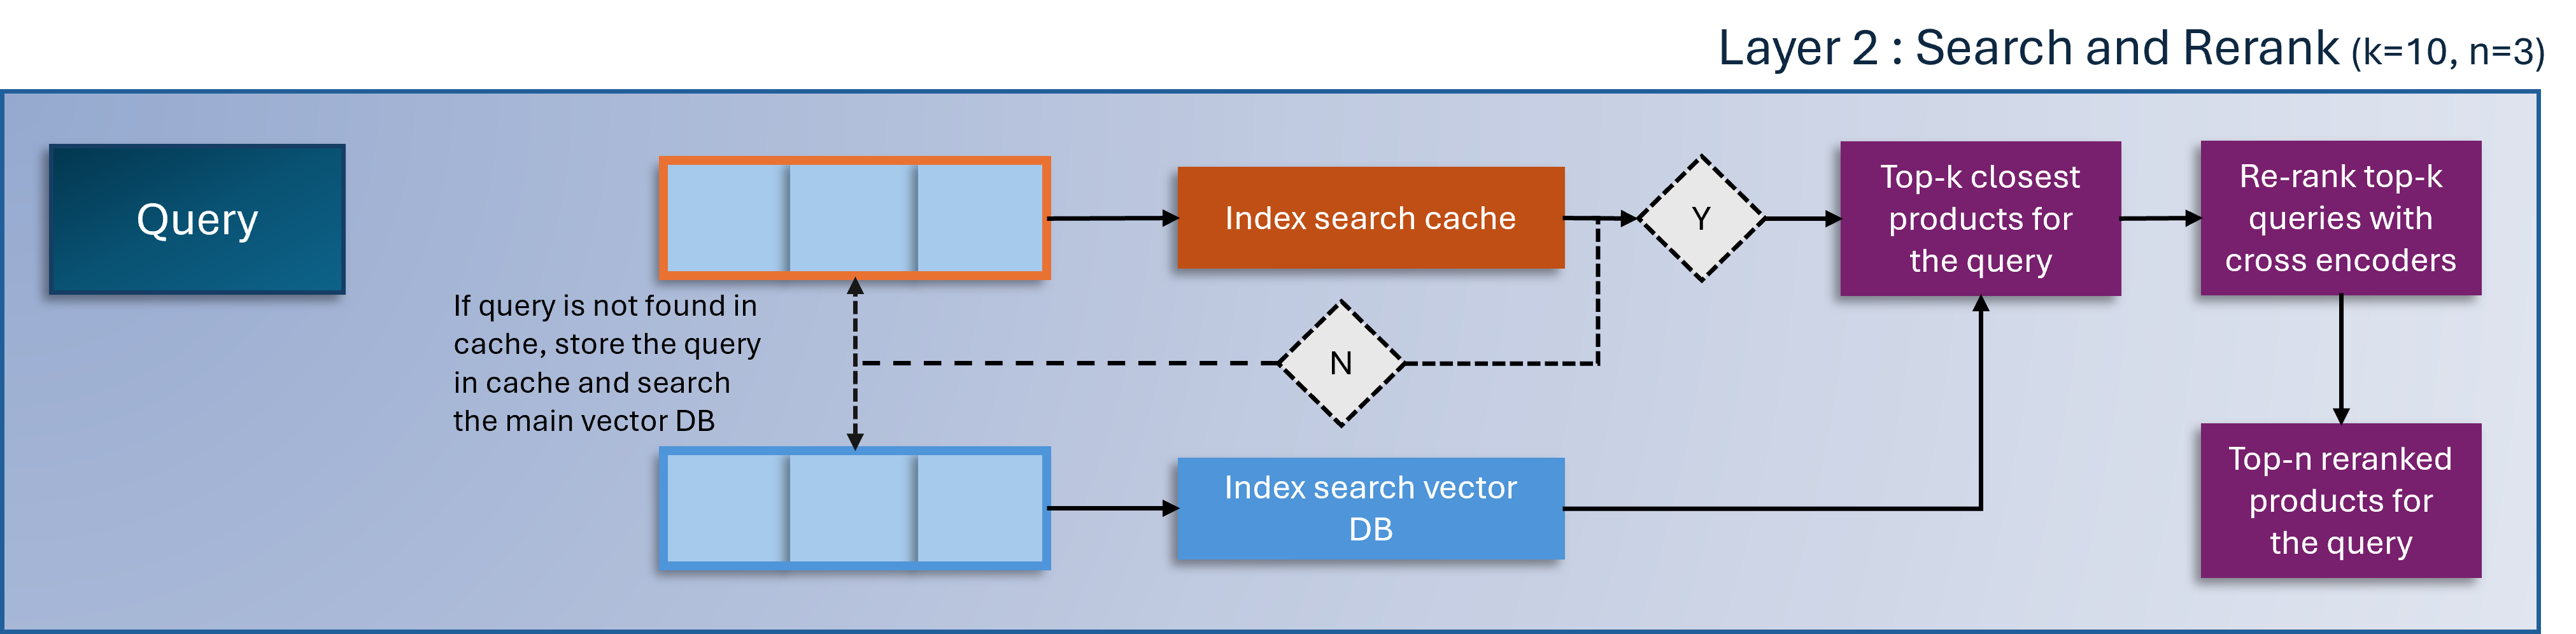

<a id='layer2_query'></a>
### <p style="color: #333333; background-color: #ffc0cb;"> 2.1 Implement query from either cache or main collection </p>

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [21]:
# Changes the pandas settings for better output view beyond this cell
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 0)

In [22]:
# Setup a cache collection named 'ProductsCache' in Chroma using the client.
# Associate the same embedding_function from SentenceTransformer with the collection for document embedding.
cache_collection = client.get_or_create_collection(name='ProductsCache', embedding_function=embedding_function)

# Set a threshold value for cache search to control the similarity threshold.
threshold = 0.2

In [23]:
def query_from_main_or_cache_collection(query):
    # Initialize lists and DataFrame to store query results
    ids = []
    documents = []
    distances = []
    metadatas = []
    results_df = pd.DataFrame()

    # Search the cache collection first
    cache_results = cache_collection.query(
        query_texts=query,
        n_results=1
    )

    # If the cache is empty or the distance exceeds the threshold, query the main collection
    if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
        # Query the main collection and return the top 10 results
        results = all_products_collection.query(
            query_texts=query,
            n_results=10
        )

        # Store the query in the cache collection as a document for future reference
        # Store retrieved text, ids, distances, and metadatas in cache_collection for easy retrieval
        keys = []
        values = []
        for key, val in results.items():
            if val is None:
                continue
            for i in range(10):
                keys.append(str(key) + str(i))
                values.append(str(val[0][i]))

        cache_collection.add(
            documents=[query],
            ids=[query],
            metadatas=dict(zip(keys, values))
        )

        print("[INFO] : Not found in cache. Found in main collection.")

        # Construct DataFrame from query results
        result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0],
                       'Distances': results['distances'][0], "IDs": results["ids"][0]}
        results_df = pd.DataFrame.from_dict(result_dict)

    # If the distance is within the threshold, return the results from cache
    elif cache_results['distances'][0][0] <= threshold:
        cache_result_dict = cache_results['metadatas'][0][0]

        # Extract data from cache result dictionary
        for key, value in cache_result_dict.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)

        print("[INFO] : Found in cache!")

        # Create DataFrame from cache query results
        results_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
        })

    return results_df

In [24]:
# Read the user query
query = input()

black t-shirt


In [25]:
# Query the main or cache collection based on the input query
results_df = query_from_main_or_cache_collection(query)

# Display the query results DataFrame
results_df

[INFO] : Not found in cache. Found in main collection.


Metadatas  \
0  {'p_id': 14937456}   
1  {'p_id': 16294398}   
2  {'p_id': 17562104}   
3  {'p_id': 19270830}   
4  {'p_id': 19186654}   
5  {'p_id': 19214734}   
6  {'p_id': 19195580}   
7  {'p_id': 14154748}   
8  {'p_id': 16549154}   
9  {'p_id': 17837472}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Documents  \
0  Name : WEDZE By Decathlon Men Black Solid Thermal Tops\n Category : Thermal Tops\n Price : 699\n Color : Black\n Brand : WEDZE By Decathlon\n Rating : 4.31\n Description : Black solid thermal t-shirt, has round neck, long sleevesThe model (height 6') is wearing a size M100.0% Polyester, Machine Wash\n Attributes : {'Body or Garment Size': 'Garment Measurements in', 'Fabric': 'Polyester', 'Multipack Set': 'Single', 'Neck': 'Round Neck', 'Sleeve Length': 'Long Sleeves', 'Sustainable': 'Regular', 'Wash Care': 'Machine Wash'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1  Name : Chemistry Women Black Solid T-shirt with Joggers And Snood\n Category : T-shirt, Joggers, Snood\n Price : 2899\n Color : Black\n Brand : Chemistry\n Rating : 3.00\n Description : This Co-Ord Set consists of T-shirt, Joggers and Snood Black self design T-shirt ,has a round neck, three-quarter sleeves Black solid solid ,has a drawstring closure95% Polyester / 5% Spandex Machine-washThe model (height 5'8) is wearing a size S\n Attributes : {'Add-Ons': 'NA', 'Bottom Closure': 'Drawstring', 'Bottom Fabric': 'Cotton Blend', 'Bottom Pattern': 'Solid', 'Bottom Type': 'Trousers', 'Character': 'NA', 'Lining': 'NA', 'Neck': 'Round Neck', 'Number of Pockets': 'NA', 'Occasion': 'Casual', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sustainable': 'Regular', 'Top Fabric': 'Cotton Blend', 'Top Pattern': 'Self Design', 'Top Type': 'T-shirt', 'Trends': 'NA', 'Wash Care': 'Machine Wash'}                                                                                                                                                                                                                                                                                                                                    
2  Name : Chkokko Women Black Solid T-Shirt & Shorts\n Category : T-Shirt, Shorts\n Price : 33

---
<a id='layer2_reranking'></a>
## <p style="color: #333333; background-color: #ffc0cb;"> 2.2 Re-Ranking with a Cross Encoder </p>

Re-ranking the results obtained from semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

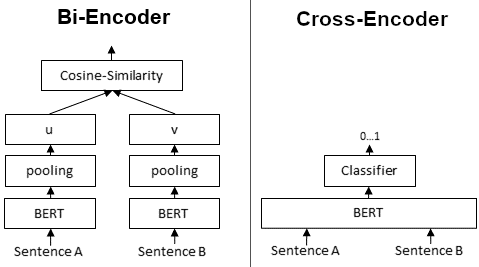

<br>

In [26]:
# Initialize the cross encoder model with the 'ms-marco-MiniLM-L-6-v2'
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

C:\Users\Shruthip\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [27]:
# Input (query, response) pairs for each of the top 10 responses received from the semantic search to the cross encoder

# Prepare inputs for cross-encoder prediction by pairing each query with each response from the results DataFrame.
cross_inputs = [[query, response] for response in results_df['Documents']]

# Predict cross-encoder scores for each query-response pair.
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [28]:
# Store the reranked scores in the results DataFrame under the column 'Reranked_scores'.
results_df['Reranked_scores'] = cross_rerank_scores

# Display the updated results DataFrame.
results_df

Metadatas  \
0  {'p_id': 14937456}   
1  {'p_id': 16294398}   
2  {'p_id': 17562104}   
3  {'p_id': 19270830}   
4  {'p_id': 19186654}   
5  {'p_id': 19214734}   
6  {'p_id': 19195580}   
7  {'p_id': 14154748}   
8  {'p_id': 16549154}   
9  {'p_id': 17837472}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Documents  \
0  Name : WEDZE By Decathlon Men Black Solid Thermal Tops\n Category : Thermal Tops\n Price : 699\n Color : Black\n Brand : WEDZE By Decathlon\n Rating : 4.31\n Description : Black solid thermal t-shirt, has round neck, long sleevesThe model (height 6') is wearing a size M100.0% Polyester, Machine Wash\n Attributes : {'Body or Garment Size': 'Garment Measurements in', 'Fabric': 'Polyester', 'Multipack Set': 'Single', 'Neck': 'Round Neck', 'Sleeve Length': 'Long Sleeves', 'Sustainable': 'Regular', 'Wash Care': 'Machine Wash'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1  Name : Chemistry Women Black Solid T-shirt with Joggers And Snood\n Category : T-shirt, Joggers, Snood\n Price : 2899\n Color : Black\n Brand : Chemistry\n Rating : 3.00\n Description : This Co-Ord Set consists of T-shirt, Joggers and Snood Black self design T-shirt ,has a round neck, three-quarter sleeves Black solid solid ,has a drawstring closure95% Polyester / 5% Spandex Machine-washThe model (height 5'8) is wearing a size S\n Attributes : {'Add-Ons': 'NA', 'Bottom Closure': 'Drawstring', 'Bottom Fabric': 'Cotton Blend', 'Bottom Pattern': 'Solid', 'Bottom Type': 'Trousers', 'Character': 'NA', 'Lining': 'NA', 'Neck': 'Round Neck', 'Number of Pockets': 'NA', 'Occasion': 'Casual', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sustainable': 'Regular', 'Top Fabric': 'Cotton Blend', 'Top Pattern': 'Self Design', 'Top Type': 'T-shirt', 'Trends': 'NA', 'Wash Care': 'Machine Wash'}                                                                                                                                                                                                                                                                                                                                    
2  Name : Chkokko Women Black Solid T-Shirt & Shorts\n Category : T-Shirt, Shorts\n Price : 33

In [29]:
# Sort the results DataFrame by 'Reranked_scores' in descending order and select the top 3 entries.
top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)[:3]

# Display the top 3 reranked entries.
top_3_rerank

Metadatas  \
1  {'p_id': 16294398}   
2  {'p_id': 17562104}   
0  {'p_id': 14937456}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Documents  \
1  Name : Chemistry Women Black Solid T-shirt with Joggers And Snood\n Category : T-shirt, Joggers, Snood\n Price : 2899\n Color : Black\n Brand : Chemistry\n Rating : 3.00\n Description : This Co-Ord Set consists of T-shirt, Joggers and Snood Black self design T-shirt ,has a round neck, three-quarter sleeves Black solid solid ,has a drawstring closure95% Polyester / 5% Spandex Machine-washThe model (height 5'8) is wearing a size S\n Attributes : {'Add-Ons': 'NA', 'Bottom Closure': 'Drawstring', 'Bottom Fabric': 'Cotton Blend', 'Bottom Pattern': 'Solid', 'Bottom Type': 'Trousers', 'Character': 'NA', 'Lining': 'NA', 'Neck': 'Round Neck', 'Number of Pockets': 'NA', 'Occasion': 'Casual', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sustainable': 'Regular', 'Top Fabric': 'Cotton Blend', 'Top Pattern': 'Self Design', 'Top Type': 'T-shirt', 'Trends': 'NA', 'Wash Care': 'Machine Wash'}   
2  Name : Chkokko Women Black Solid T-Shirt & Shorts\n Category : T-Shirt, Shorts\n Price : 3349\n Color : Black\n Brand : Chkokko\n Rating : nan\n Description : T-Shirt &amp; Shorts&nbsp; Black solid t-shirt has round neck , short sleeves Black solid shorts has slip-on closure and two pockets&nbsp; Cotton Blend&nbsp; Machine WashThe model (height 5'8") is wearing a size S\n Attributes : {'Add-Ons': 'NA', 'Bottom Closure': 'Slip-On', 'Bottom Fabric': 'Cotton Blend', 'Bottom Pattern': 'Solid', 'Bottom Type': 'Shorts', 'Character': 'NA', 'Lining': 'NA', 'Neck': 'Round Neck', 'Number of Pockets': '2', 'Occasion': 'Casual', 'Sleeve Length': 'Short Sleeves', 'Sustainable': 'Regular', 'Top Fabric': 'Cotton Blend', 'Top Pattern': 'Solid', 'Top Type': 'T-shirt', 'Trends': 'NA', 'Wash Care': 'Machine Wash', 'Wedding': 'NA'}                                                                  
0  Name : WEDZE By Decathlon Men Black Solid Thermal Tops\n Category : Thermal Tops\n Price : 699\n Color : Black\n Brand : WEDZE By Decathlon\n Rating : 4.31\n Description : Black solid thermal t-shirt, has round neck, long sleevesThe model (height 6') is wearing a size M100.0% Polyester, Machine Wash\n Attributes : {'Body or Garment Size': 'Garment Measurements in', 'Fabric': 'Polyester', 'Multipack Set': 'Single', 'Neck': 'Round Neck', 'Sleeve Length': 'Long Sleeves', 'Sustainable': 'Regular', 'Wash Care': 'Machine Wash'}                                                                                                                                                                                                                                                                                                                                                                          

    Distances   IDs  Reranked_scores  
1  340.447083  7277  5.665212         
2  345.013641  7090  5.011156         
0  317.090454  1495  4.765653

<a id='layer2_all'></a>
## <p style="color: #333333; background-color: #ffc0cb;"> 2.3 Semantic Search with Re-ranking </p>

In [30]:
def SemanticSearchWithReranking(query=None, top_n=3):
    # If query is not provided, prompt the user to enter a query
    if query is None:
        query = input()
    
    print()    
    print('*'*50)
    print('Query : ', query)
    print('*'*50)
    print()

    # Query the main or cache collection based on the input query
    query_results_df = query_from_main_or_cache_collection(query)
    
    # Prepare inputs for cross-encoder prediction and predict rerank scores
    cross_inputs = [[query, response] for response in query_results_df['Documents']]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)
    
    # Store reranked scores in the results DataFrame
    query_results_df['Reranked_scores'] = cross_rerank_scores
    
    # Select top n reranked entries
    top_n_rerank = query_results_df.sort_values(by='Reranked_scores', ascending=False)[:top_n]

    return top_n_rerank

In [31]:
# An example semantic search
SemanticSearchWithReranking('green fabric kurta with floral printed')


**************************************************
Query :  green fabric kurta with floral printed
**************************************************

[INFO] : Not found in cache. Found in main collection.


Metadatas  \
1  {'p_id': 10808284}   
0  {'p_id': 13109820}   
5  {'p_id': 16629332}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Documents  \
1  Name : AHIKA Floral Print Straight Cotton Kurta With Keyhole Neck\n Category : Kurta\n Price : 1198\n Color : Green\n Brand : AHIKA\n Rating : 4.09\n Description : Make a statement with this green kurta that embodies the beauty of simple style. This straight kurta with pastel floral print all-over accents keyhole neck that makes for an ideal piece for both day and night &nbsp; Colour: Green with white floral accents keyhole neck&nbsp; 3/Q roll-up sleeves straight silhouette&nbsp;with a firm drape Knee length Cotton, Machine-wash The model (height 5'8") is wearing a size S The model (height 5'8") is wearing a size S\n Attributes : {'Body Shape ID': '424', 'Body or Garment Size': 'Garment Measurements in', 'Colour Family': 'Pastel', 'Design Styling': 'Regular', 'Fabric': 'Cotton', 'Fabric 2': 'NA', 'Fabric Purity': 'Pure', 'Hemline': 'Straight', 'Length': 'Calf Length', 'Main Trend': 'Floral', 'Neck': 'Keyhole Neck', 'Number of Pockets': 'NA', 'Occasion': 'Daily', 'Ornamentation': 'NA', 'Pattern': 'Printed', 'Print or Pattern Type': 'Floral', 'Shape': 'Straight', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sleeve Styling': 'Roll-Up Sleeves', 'Slit Detail': 'Side Slits', 'Stitch': 'Ready to Wear', 'Sustainable': 'Regular', 'Technique': 'NA', 'Wash Care': 'Machine Wash', 'Weave Pattern': 'Regular', 'Weave Type': 'Machine Weave'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

---
---
<a id='layer3'></a>
## <p style="color: #ffd700; background-color: #006400;"> Layer 3 : Generative Search - Bringing it All ! </p>

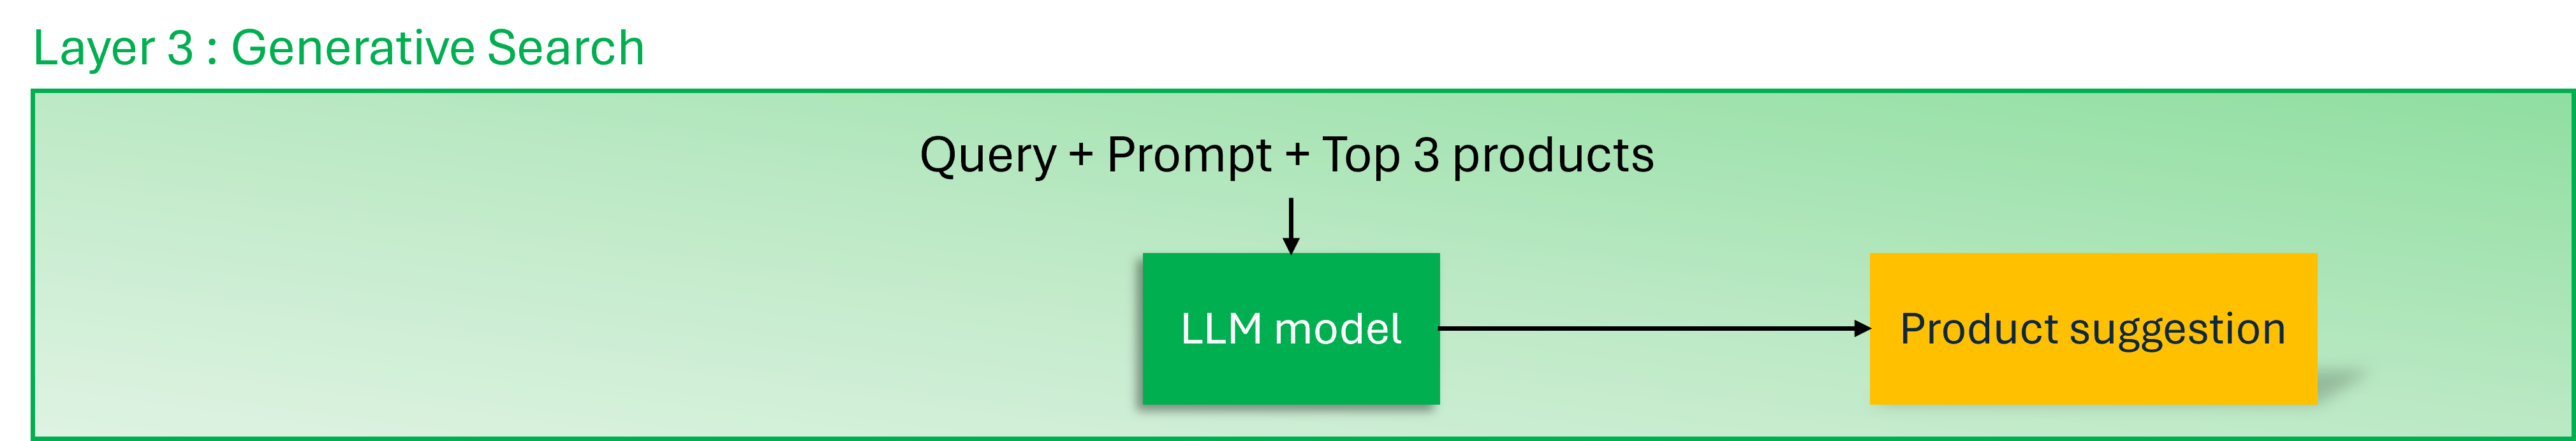

Now that we have the final top semantic search results with reranking, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query rather than returning the stored result.

In [32]:
with open("OpenAI_API_Key.txt", "r") as f:
    openai.api_key = ' '.join(f.readlines())

In [82]:
# Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a fashion expert who can showcase a product in such a way that the user gets satisfied."},
                {"role": "user", "content": f"""You are a fashion expert who can showcase a product in such a way that the user gets satisfied.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of fashion products database in the dataframe '{results_df}'. These search results are essentially a product that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual description of the product.

                                                Use the documents in '{results_df}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return product details.
                                                Also ,Use the data from 'Attributes' and provide an answer related to the query '{query}'

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If you can't provide the complete answer, please provide a disclaimer.
                                                4. Do not use keywords which are similar to 'database', 'results', 'search'
                                                5. Do not start with a welcome note and do not close the conversation with a follow up statement or question else you will be heavily penalized.
                                                
                                                The generated response should answer the query directly addressing the user and avoiding additional information. 
                                                If you think that the query is not relevant to the document, reply with a best possible response.
                                                Provide the final simple, clear and natural response in a well-formatted and easily readable text.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

# Display an image corresponding to a product result from the dataframe.
def display_image(result_df):
    # Extract metadata from the input result
    metadata_string = result_df['Metadatas']
    
    # Convert metadata string to dictionary and extract image number
    try:
        metadata_dict = ast.literal_eval(metadata_string)
        imgNo_string = str(metadata_dict['p_id'])
    except ValueError:
        imgNo_string = str(metadata_string['p_id'])
    
    # Construct path to the image
    img_path = "dataset\\images\\"+ imgNo_string +".jpg"
    
    # Display the image
    image = Image(img_path, width="250")
    display(image)

def print_response_and_display_image(result_df, response, result_text = "Response:"):
    # Print the generated response
    print()
    print("*"*50)
    print(result_text)
    print("*"*50)
    print("\n".join(response))
    print()

    # Display the image of the suggested product
    print("The suggested product looks like ")
    display_image(result_df)

In [52]:
# Perform generative search by combining semantic search with reranking and generating a response.
def GenerativeSearch(query=None):
    # If query is not provided, prompt the user to input a query
    if query is None:
        query = input()
    
    # Perform semantic search with reranking to retrieve the top 3 most relevant results
    semantic_search_df = SemanticSearchWithReranking(query, top_n=3)
    # Reset the index for proper iteration
    semantic_search_df = semantic_search_df.reset_index()

    for index, result in semantic_search_df.iterrows():
        if index == 0:
            # Generate a response based on the query and retrieved information
            response = generate_response(query, result[['Documents']])
            print_response_and_display_image(result_df=result, response=response, result_text="Top product")
        else:
            # Check if the current result is close to the previous result
            if abs(previous_rank_score - result['Reranked_scores']) <= 0.5:
                # Generate a response based on the query and retrieved information
                response = generate_response(query, result[['Documents']])
                print_response_and_display_image(result_df=result, response=response, result_text="Similar product")
            # If not close enough, break the loop and stop suggesting similar products
            else:
                break
        # Store the current rerank score to compare in the next cycle
        previous_rank_score = result['Reranked_scores']


**************************************************
Query :  blue jeans
**************************************************

[INFO] : Found in cache!

**************************************************
Top product
**************************************************
These Levis Women Blue 710 Super Skinny Fit Light Fade Stretchable Jeans are a perfect choice for a clean and chic look. The jeans feature a super skinny fit with a mid-rise waist and a light fade blue shade. Made from a stretchable fabric blend of 80% cotton, 18% polyester, and 2% elastane, these jeans offer both style and comfort. They come with five pockets and are machine-washable for easy care. Perfect for a casual occasion, these jeans are designed with a regular length and a waistband with belt loops. Get your hands on these trendy jeans for a fashion-forward statement!

The suggested product looks like 


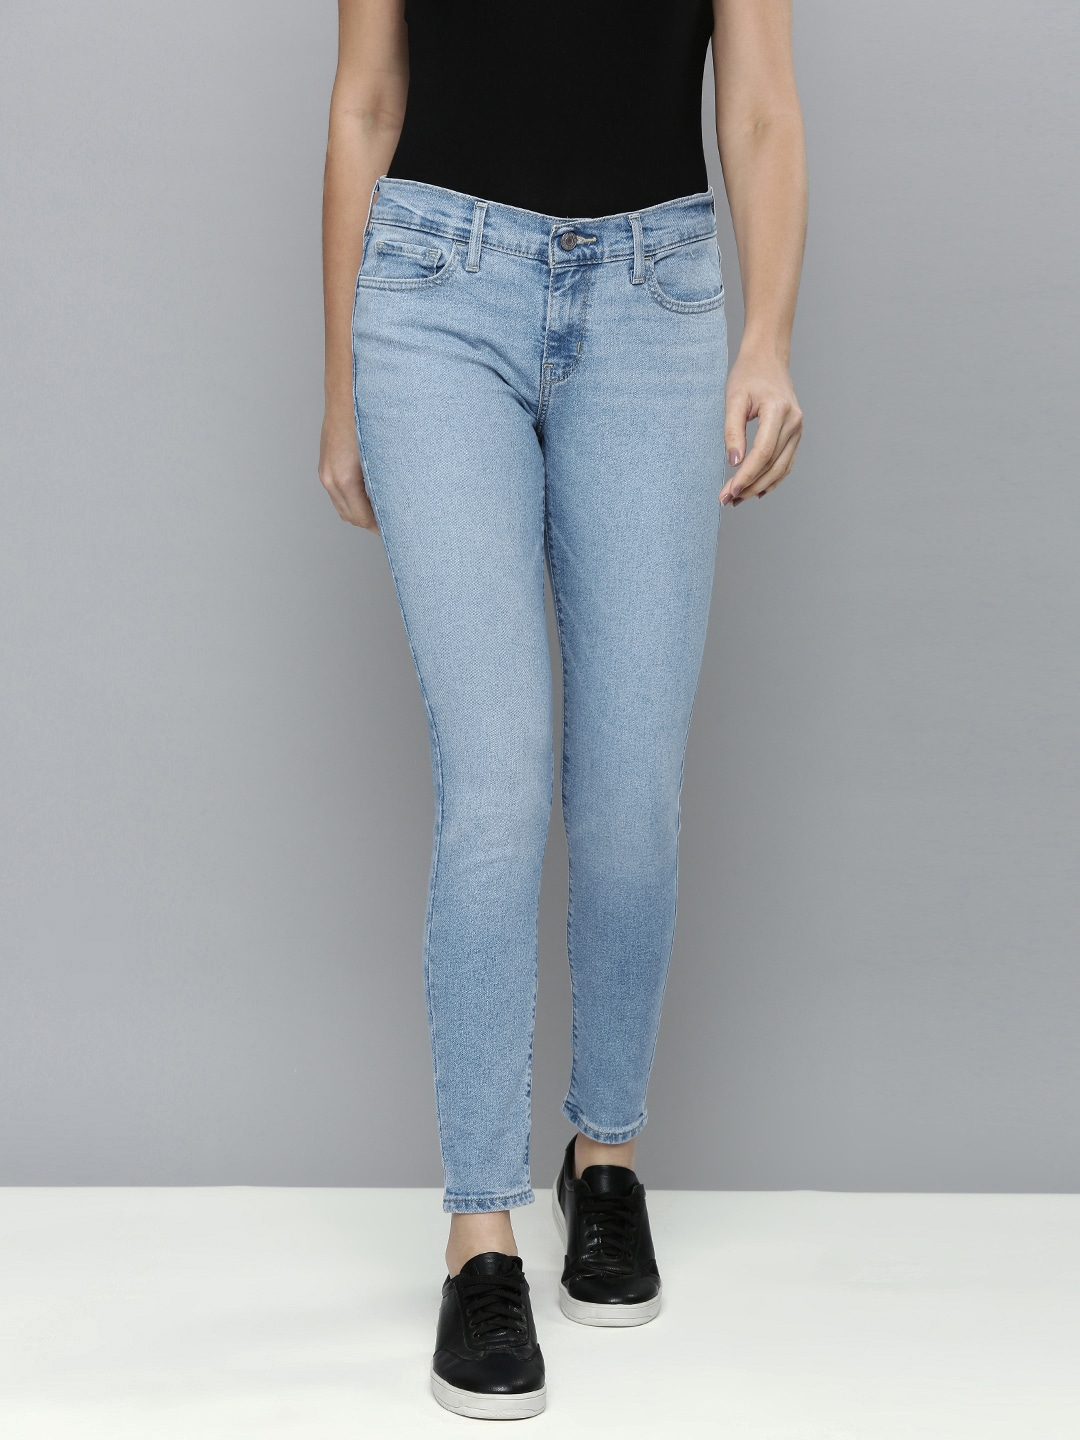


**************************************************
Similar product
**************************************************
These Calvin Klein blue jeans are a perfect choice for a clean, high-rise, and stretchable fit. They feature a straight fit style with a regular length, making them a versatile and comfortable option for casual occasions. The cotton fabric ensures durability and easy care with machine wash. The jeans come with 5 pockets and a waistband with belt loops. The shade is a colored blue that does not fade over time. Enjoy the stylish and practical design of these Calvin Klein Women's Blue Stretchable Jeans.

The suggested product looks like 


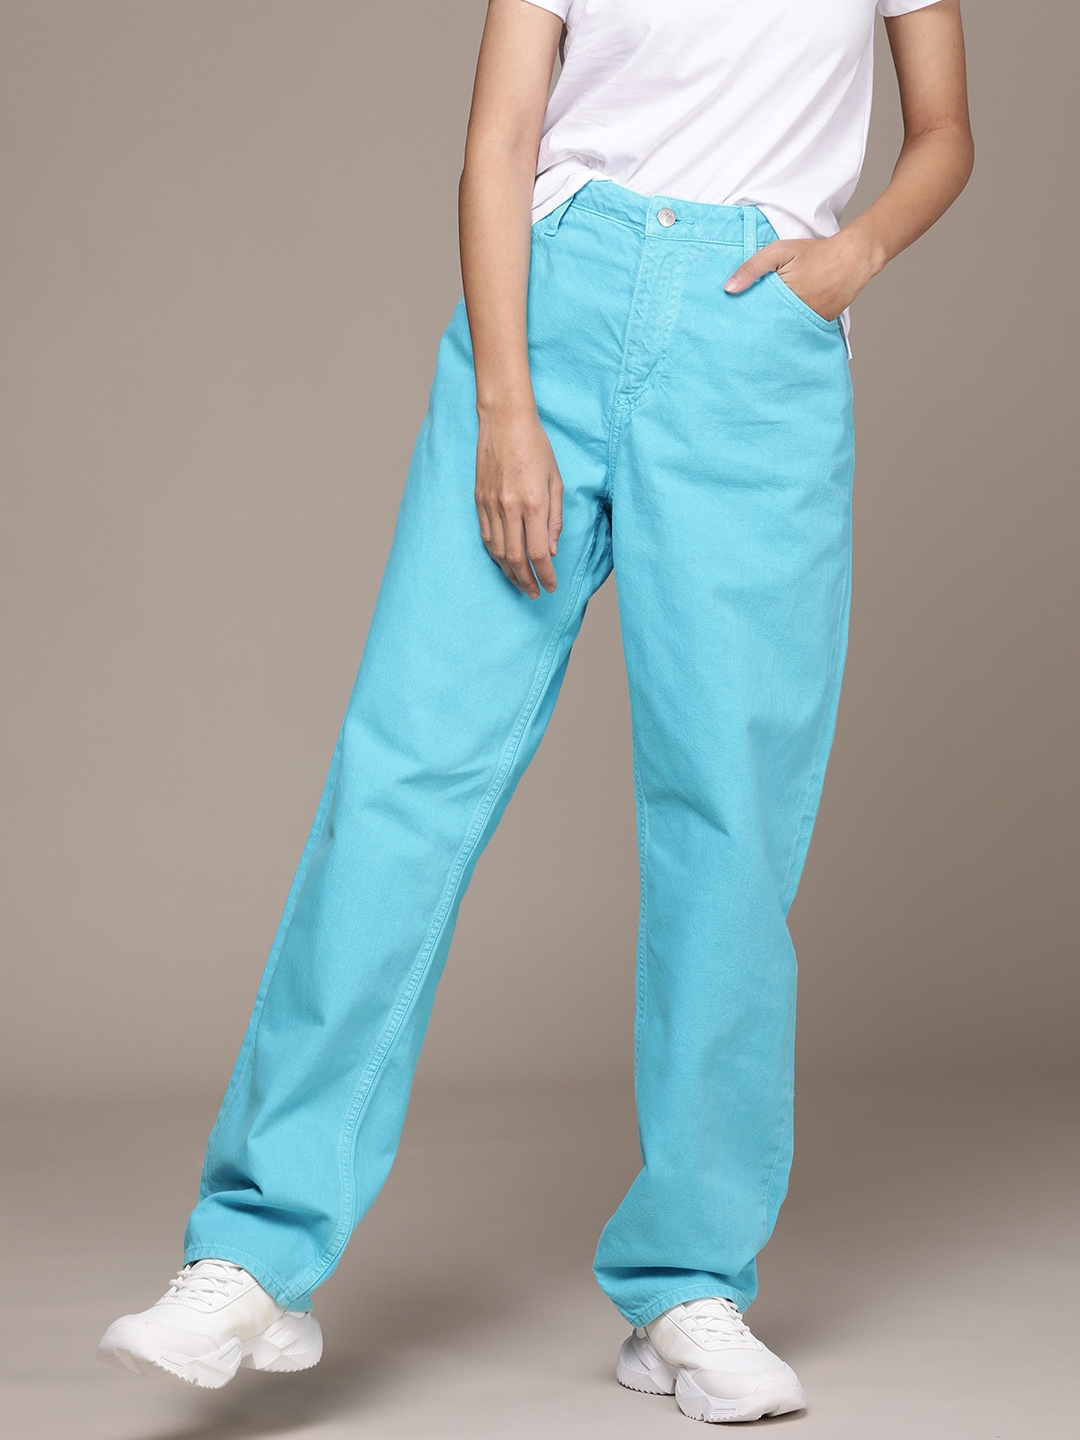


**************************************************
Similar product
**************************************************
The Levis Women Blue 721 Skinny Fit High-Rise Stretchable Jeans are a stylish choice for those in search of blue jeans. These jeans offer a clean look with a skinny fit and a high-rise waist. They are made of 82% cotton, 17% polyester, and 1% elastane, making them stretchable and comfortable to wear. The dark shade of blue is designed to not fade over time. Additionally, the jeans feature 5 pockets and can be machine-washed for easy care. They are suitable for casual occasions, and the waistband includes belt loops. You can find these jeans in a regular length and a waist size of 28.

Price: 3799
Color: Blue
Fit: Skinny Fit
Waist Rise: High-Rise
Fabric: 82% cotton, 17% polyester, 1% elastane

These Levis Women Blue 721 Jeans are a great option for your search for blue jeans - offering style, comfort, and quality in one package.

The suggested product looks like 


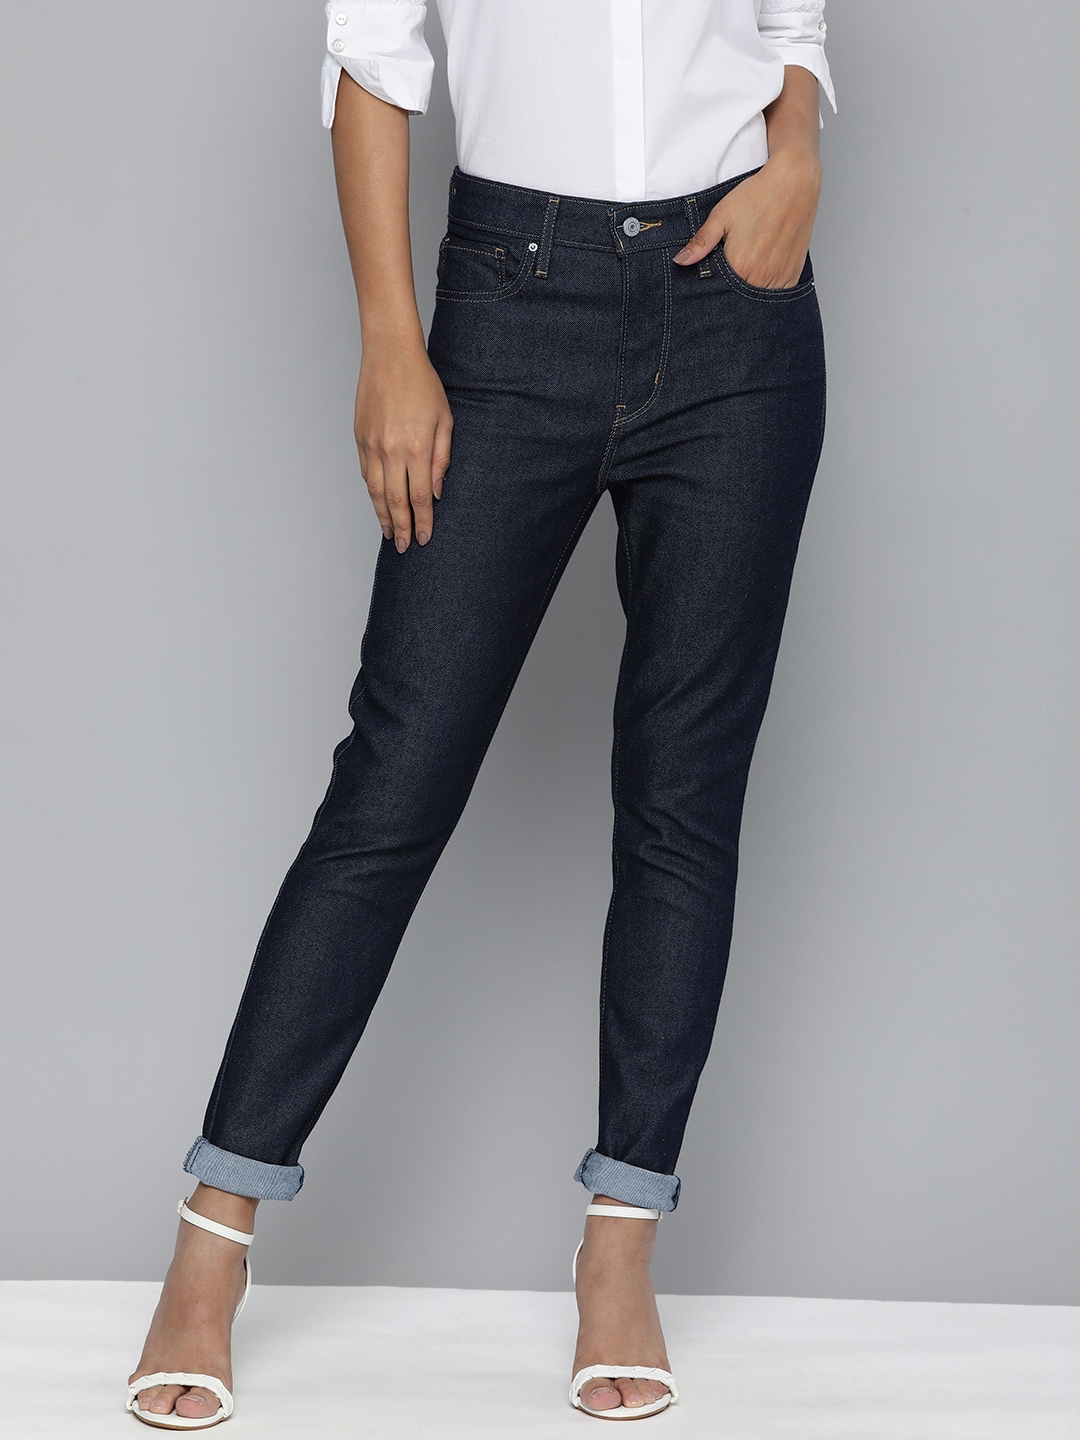

In [88]:
# An example generative search
GenerativeSearch('blue jeans')

---
---
<a id='exp'></a>
## <p style="color: #ffd700; background-color: #006400;"> Experimenting with queries </p>

<a id='exp_1'></a>
### <p style="color: #333333; background-color: #ffc0cb;"> Query 1 : "Maroon blazer for casual occasion from Van Heusen" </p>

In [36]:
SemanticSearchWithReranking("Maroon blazer for casual occasion from Van Heusen")


**************************************************
Query :  Maroon blazer for casual occasion from Van Heusen
**************************************************

[INFO] : Not found in cache. Found in main collection.


Metadatas  \
0  {'p_id': 16442258}   
1  {'p_id': 18152576}   
4  {'p_id': 16398418}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Documents  \
0  Name : Van Heusen Woman Women Maroon Solid Single-Breasted Formal Blazer\n Category : Blazer\n Price : 2599\n Color : Maroon\n Brand : Van Heusen Woman\n Rating : 4.58\n Description : Maroon solid regular-fit casual blazer, has a notched lapel, long sleeves, single-breasted with double button closure, two flap pockets, and a double-vented back hem 90% Polyester and 10% Spandex Dry clean Regular-fit The model (height 6') is wearing a size XS\n Attributes : {'Body Shape ID': '443,324,333,424', 'Body or Garment Size': 'Garment Measurements in', 'Closure': 'Button', 'Collar': 'Notched Lapel', 'Fabric': 'Polyester', 'Fabric Type': 'NA', 'Fit': 'Regular Fit', 'Front Styling': 'Single-Breasted', 'Length': 'Regular', 'Lining Fabric': 'Satin', 'Occasion': 'Formal', 'Pattern': 'Solid', 'Sleeve Length': 'Long Sleeves', 'Sustainable': 'Regular', 'Wash Care': 'Dry Clean'}   
1  Name : Van Heusen Woman Maroon Solid Single-Breasted Casual Blazer\n Category : Blazer\n Price : 3999\n Color : Maroon\n Brand : Van Heusen Woman\n Rating : nan\n Description : Maroon solid slim-fit casual blazer, has notched lapel, single-breasted with button closure, long sleeves, two welt pockets 64% Polyester, 34% Viscose and 2% Elastane Dry-clean Slim-fit The model (height 5'8'') is wearing a size XS\n Attributes : {'Body Shape ID': '324,333,424', 'Body or Garment Size': 'Garment Measurements in', 'Closure': 'Button', 'Collar': 'Notched Lapel', 'Fabric': 'Polyester', 'Fabric Type': 'NA', 'Fit': 'Slim Fit', 'Front Styling': 'Single-Breasted', 'Length': 'Regular', 'Lining Fabric': 'Polyester', 'Occasion': 'Casual', 'Pattern': 'Solid', 'Sleeve Length': 'Long Sleeves', 'Sustainable': 'Regular', 'Wash Care': 'Dry Clean'}                                          
4  Name : Van Heusen Woman Women Navy Blue Checked Casual Blazer\n Category : Blazer\n Price : 3999\n Color : Navy Blue\n Brand : Van Heusen Woman\n Rating : 3.00\n Description : Navy Blue checked regular-fit single breasted front-open casual blazer, has long sleeves and single vented back hem 64% Polyester, 34% Viscose and 2% Spandex Dry Clean Regular-fit The model (height 5'8") is wearing S\n Attributes : {'Body Shape ID': '443,324,333,424', 'Body or Garment Size': 'Garment Measurements in', 'Closure': 'Button', 'Collar': 'Shawl Collar', 'Fabric': 'Polyester', 'Fabric Type': 'NA', 'Fit': 'Regular Fit', 'Front Styling': 'Single-Breasted', 'Length': 'Regular', 'Lining Fabric': 'Polyester', 'Occasion': 'Casual', 'Pattern': 'Checked', 'Sleeve Length': 'Long Sleeves', 'Sustainable': 'Regular', 'Wash Care': 'Dry Clean'}                                                  

    Distances    IDs  Reranked_scores  
0  163.145508  12832  6.865547         
1  170.755951  12716  6.635722         
4  195.148499  12800  4.584153


**************************************************
Query :  Maroon blazer for casual occasion from Van Heusen
**************************************************

[INFO] : Found in cache!

**************************************************
Top product
**************************************************
Certainly! The Maroon blazer from Van Heusen is a solid choice for a casual occasion. It features a regular fit with a notched lapel, long sleeves, and a single-breasted design with a double-button closure. The blazer also includes two flap pockets and a double-vented back hem for a stylish touch.

This versatile blazer is made of 90% Polyester and 10% Spandex, ensuring both comfort and durability. The fabric type is suitable for dry cleaning, maintaining the blazer's quality. The satin lining adds a luxurious feel to the garment.

Overall, this Maroon blazer is an excellent option for a casual setting, offering a perfect blend of style and comfort.

The suggested product looks like 


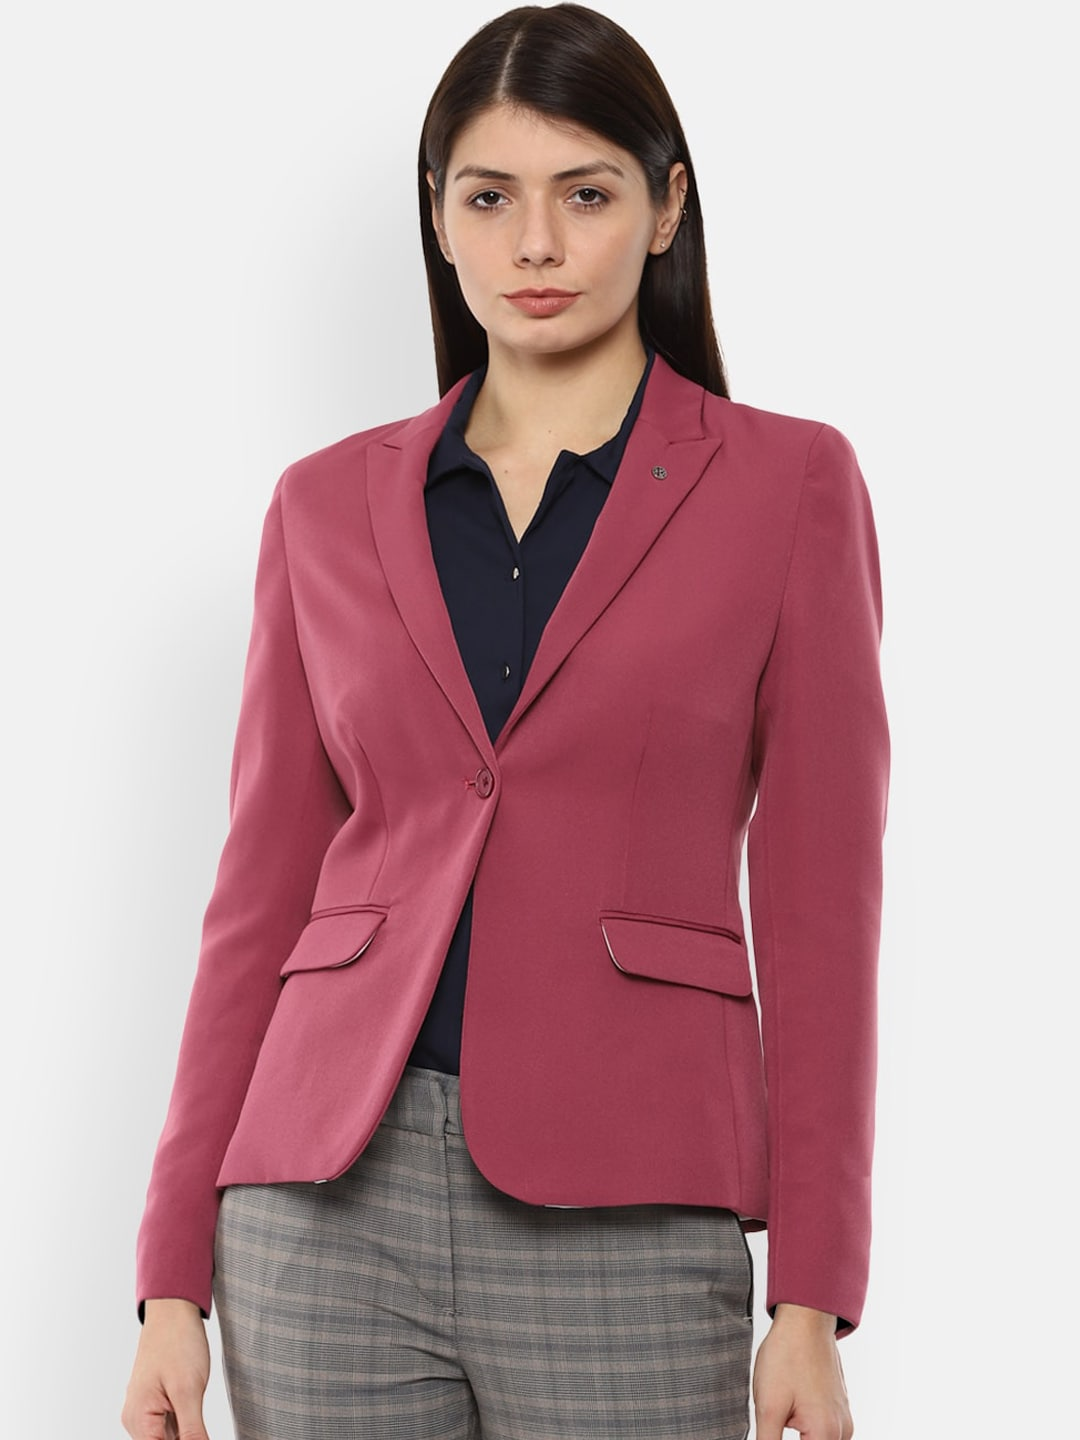


**************************************************
Similar product
**************************************************
The Van Heusen Woman Maroon Solid Single-Breasted Casual Blazer is a stylish choice for a casual occasion. This slim-fit blazer features a notched lapel, single-breasted button closure, long sleeves, and two welt pockets, making it both fashionable and functional. The blend of 64% Polyester, 34% Viscose, and 2% Elastane ensures a comfortable fit. It is recommended to dry clean this blazer for maintenance. Perfect for a casual outing, this blazer exudes a chic vibe while providing a sophisticated look.

The suggested product looks like 


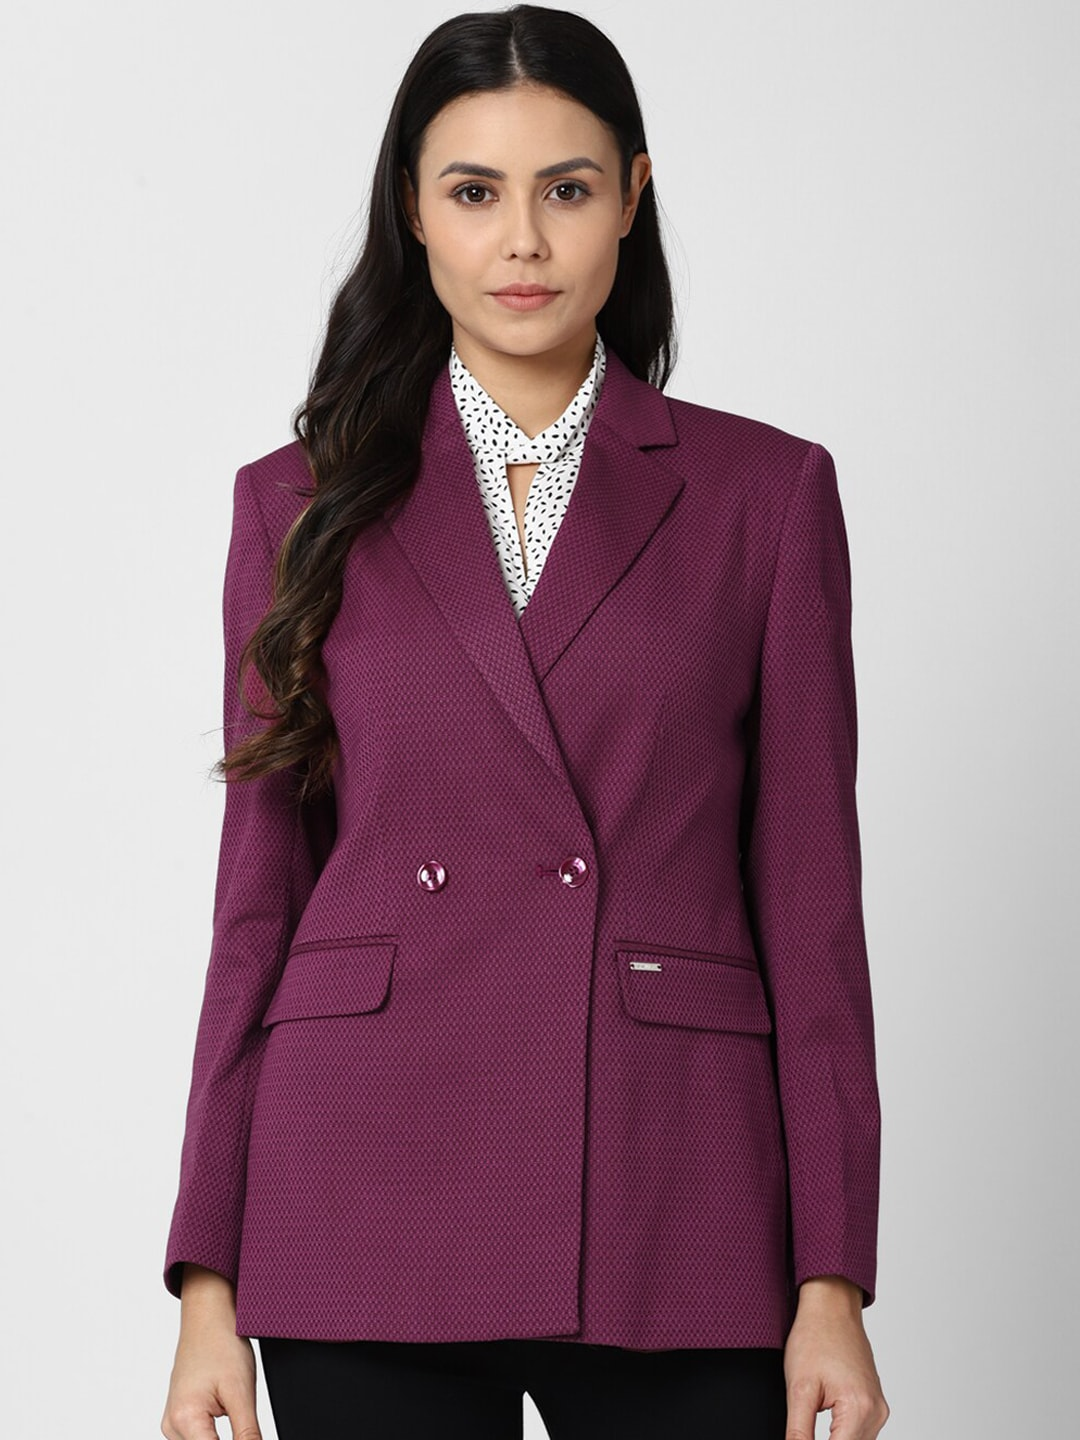

In [85]:
GenerativeSearch("Maroon blazer for casual occasion from Van Heusen")

<a id='exp_2'></a>
### <p style="color: #333333; background-color: #ffc0cb;"> Query 2 : "White anarkali kurta with a rating of more than 4"</p>

In [38]:
SemanticSearchWithReranking("White anarkali kurta with a rating of more than 4")


**************************************************
Query :  White anarkali kurta with a rating of more than 4
**************************************************

[INFO] : Not found in cache. Found in main collection.


Metadatas  \
0  {'p_id': 7156696}    
4  {'p_id': 15616828}   
6  {'p_id': 8033765}    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Documents  \
0  Name : Vishudh Women White & Navy Blue Printed Anarkali Kurta\n Category : Anarkali Kurta\n Price : 2149\n Color : White\n Brand : Vishudh\n Rating : 4.26\n Description : White and navy blue printed anarkali kurta, has a scoop neck, three-quarter sleeves, flared hemThe model (height 5'8") is wearing a size SCotton Machine-wash\n Attributes : {'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Colour Family': 'Indigo', 'Design Styling': 'Pleated', 'Fabric': 'Cotton', 'Fabric 2': 'NA', 'Fabric Purity': 'Pure', 'Hemline': 'Flared', 'Length': 'Calf Length', 'Main Trend': 'NA', 'Neck': 'Scoop Neck', 'Occasion': 'Daily', 'Ornamentation': 'NA', 'Pattern': 'Printed', 'Print or Pattern Type': 'Ethnic Motifs', 'Shape': 'Anarkali', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sleeve Styling': 'Regular Sleeves', 'Slit Detail': 'NA', 'Stitch': 'Ready to Wear', 'Technique': 'Screen Print', 'Wash Care': 'Machine Wash', 'Weave Pattern': 'Regular', 'Weave Type': 'Machine Weave'}                                                                                                                               
4  Name : Myshka Women White Anarkali Kurta With Dupatta\n Category : Kurta, Dupatta\n Price : 4999\n Color : White\n Brand : Myshka\n Rating : 4.04\n Description : Colour: white Solid Mandarin collar Long, regular sleeves Anarkali shape with panelled style Ankle length with flared hem Knitted regular cotton Comes with a dupatta Cotton Machine washDupatta Length: 2 meter (approx) The model (height 5'8) is wearing a size S\n Attributes : {'Body Shape ID': '333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Care for me': 'NA', 'Colour Family': 'Earthy', 'Design Styling': 'Panelled', 'Fabric': 'Cotton', 'Fabric 2': 'NA', 'Fabric Purity': 'Pure', 'Hemline': 'Flared', 'Length': 'Ankle Length', 'Main Trend': 'NA', 'Neck': 'Mandarin Collar', 'Number of Pockets': 'NA', 'Occasion': 'Daily', 'Ornamentation': 'NA', 'Pattern': 'Solid', 'Print or Pattern Type': 'Solid', 'Shape': 'Anarkali', 'Sleeve Length': 'Long Sleeves', 'Sleeve Styling': 'Regular Sleeves', 'Slit Detail': 'NA', 'Stitch': 'Ready to Wear', 'Sustainable': 'Regular', 'Technique': 'NA', 'Wash Care': 'Machine Wash', 'Weave Pattern': 'Regular', 'Weave Type': 'Knitted'}   
6  Name : Varanga Women Off-White & Golden Printed Anarkali Kurta\n Category : Kurta, Anarkali Kurta\n Price : 3299\n Color : Off White\n Brand : Varanga\n Rating : 4.14\n Description : Off-White and golden printed anarkali kurta, has a mandarin collar with half button placket, three-quarter sleeves, flared hemThe model (height 5'8") is wearing a size SViscose Rayon Hand-wash\n Attributes : {'Body Shape ID': '333,424', 'Body or Garment Size': 'T


**************************************************
Query :  White anarkali kurta with a rating of more than 4
**************************************************

[INFO] : Found in cache!

**************************************************
Top product
**************************************************
The white anarkali kurta from Vishudh featuring a navy blue print is a stylish and elegant choice for your wardrobe. With a rating of 4.26, this kurta is not only visually appealing but also well-received by customers. Made from pure cotton and designed with a scoop neck and three-quarter sleeves, this kurta offers comfort and style. Its flared hem adds a touch of grace to the overall look. Perfect for daily wear, this calf-length anarkali kurta is easy to care for with a simple machine wash.

The suggested product looks like 


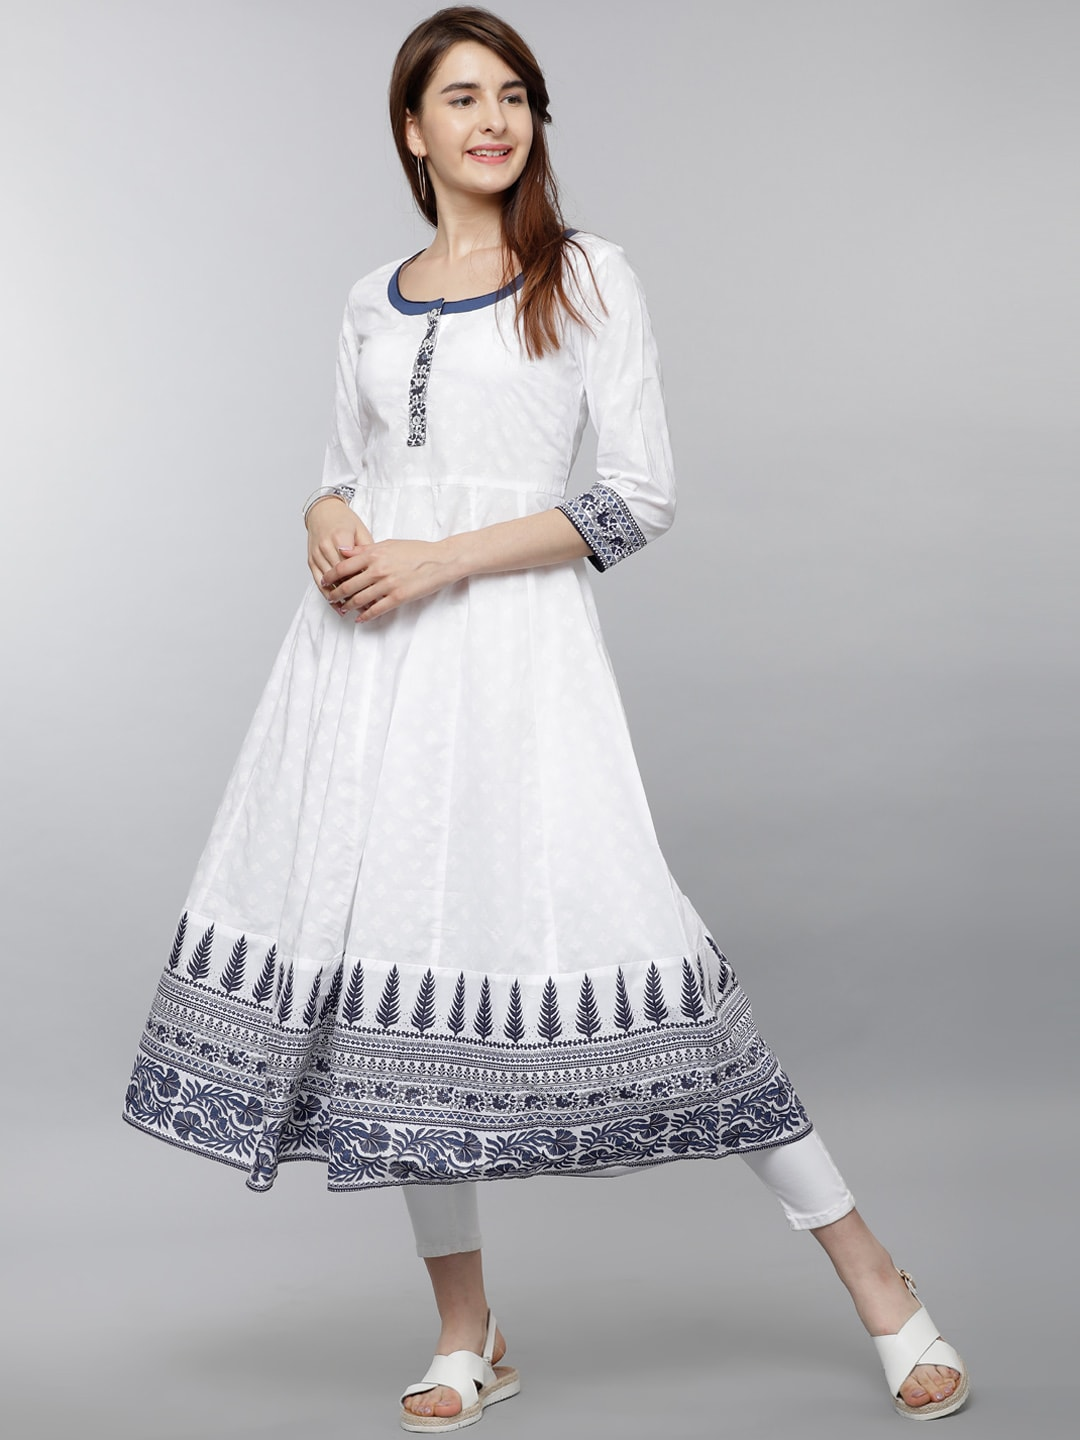


**************************************************
Similar product
**************************************************
The white Anarkali kurta by Myshka has a rating of 4.04, making it a highly rated choice. The kurta features a solid design with a mandarin collar, long sleeves, and an ankle-length flared hem. Made from regular knitted cotton, it comes with a matching dupatta for a complete look. Perfect for daily wear, this Anarkali kurta is both stylish and comfortable.

The suggested product looks like 


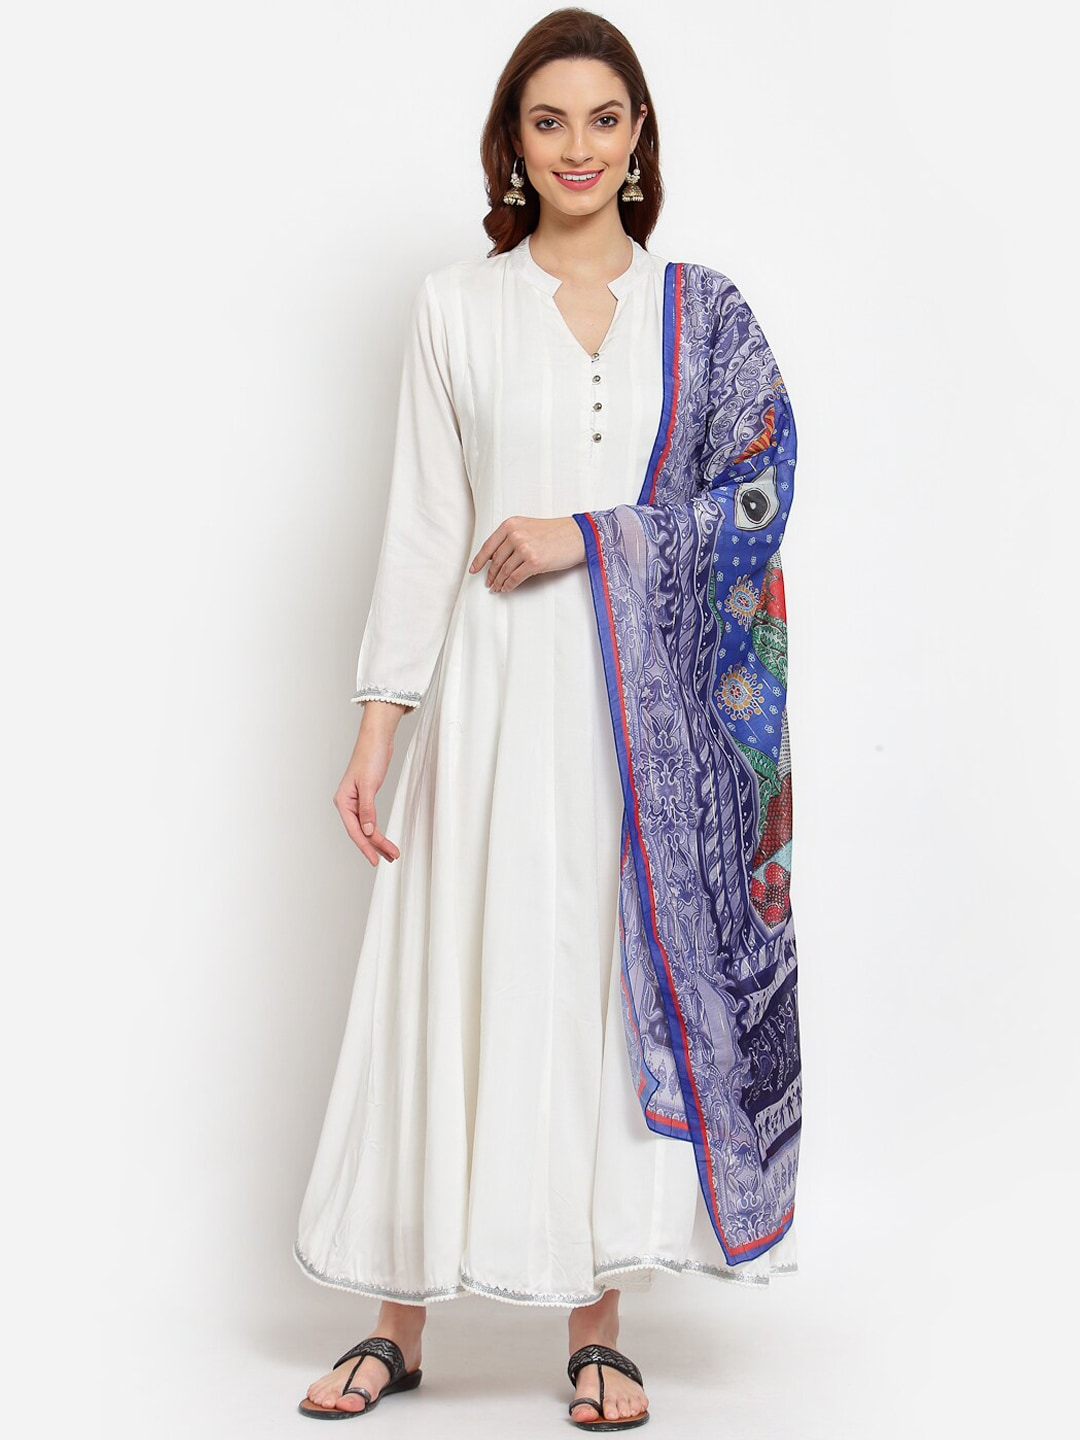


**************************************************
Similar product
**************************************************
The Varanga Women Off-White & Golden Printed Anarkali Kurta is a beautiful white anarkali kurta with a rating of 4.14, slightly above 4. It features a mandarin collar, three-quarter sleeves, and a flared hem, making it a stylish and elegant choice. The kurta is made of Viscose Rayon and is ankle-length, suitable for festive occasions. The foil print technique adds a touch of sophistication to the ethnic motifs design. To maintain its quality, it is recommended to hand wash the kurta.

The suggested product looks like 


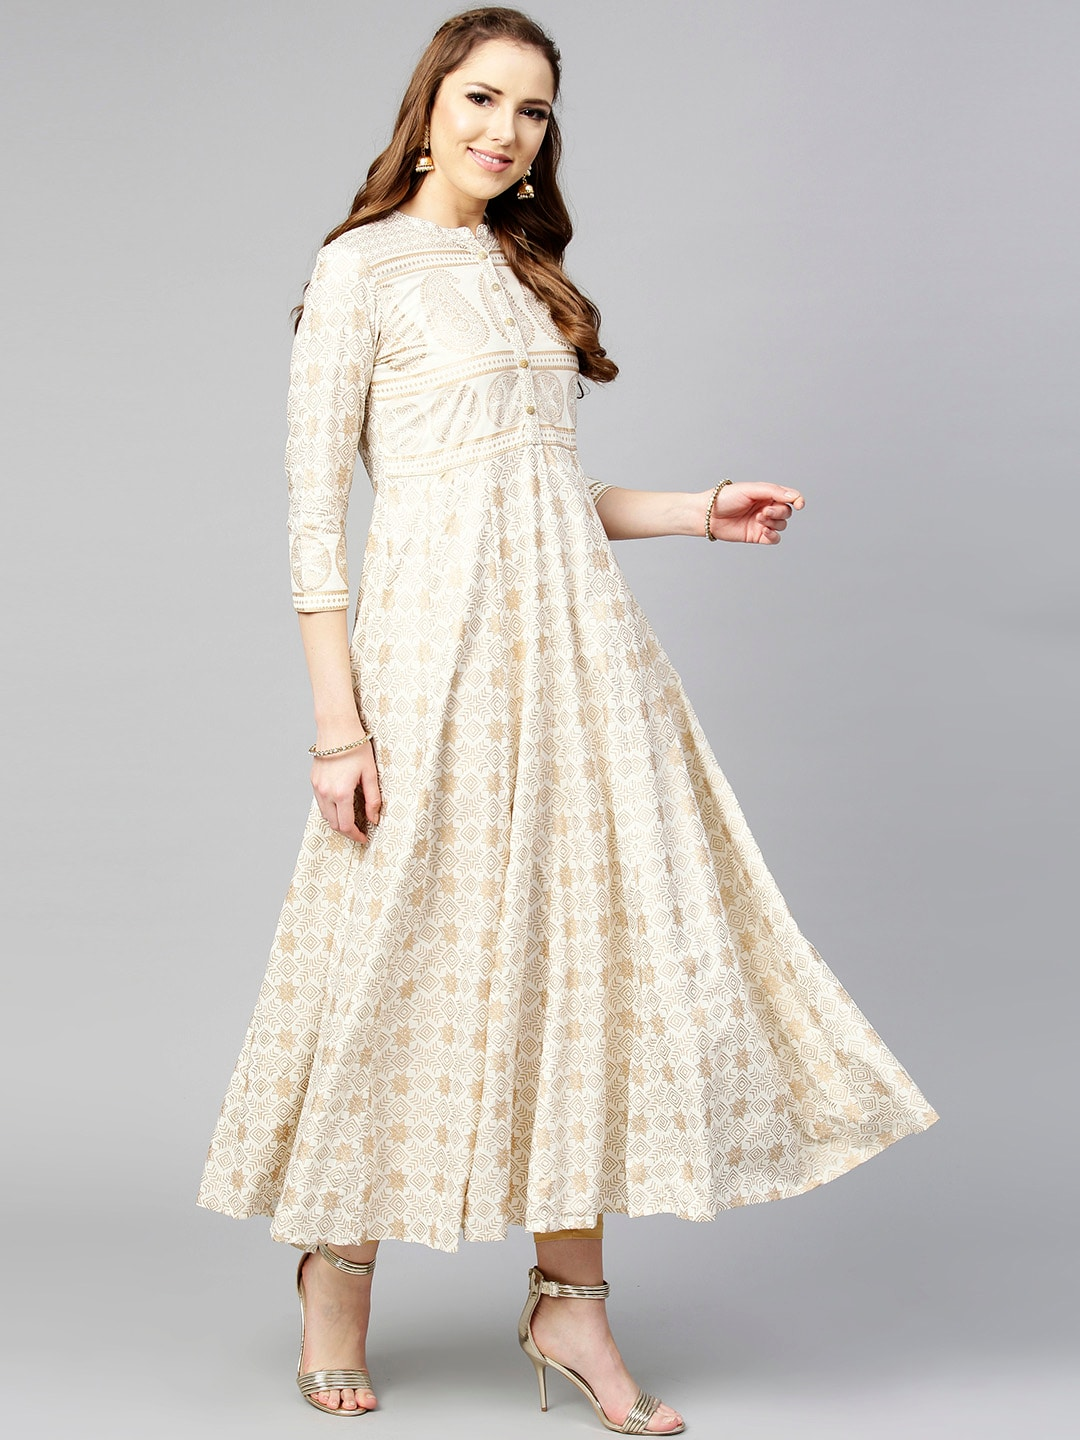

In [86]:
GenerativeSearch("White anarkali kurta with a rating of more than 4")

<a id='exp_3'></a>
### <p style="color: #333333; background-color: #ffc0cb;"> Query 3 : "Denim jacket with atleast 4 pockets, a rating of 4 and price less than 3000"</p>

In [40]:
SemanticSearchWithReranking("Denim jacket with atleast 4 pockets, a rating of 4 and price less than 3000")


**************************************************
Query :  Denim jacket with atleast 4 pockets, a rating of 4 and price less than 3000
**************************************************

[INFO] : Not found in cache. Found in main collection.


Metadatas  \
4  {'p_id': 10562374}   
0  {'p_id': 10573162}   
8  {'p_id': 10742380}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Documents  \
4  Name : The Roadster Lifestyle Co Women Blue Solid Denim Jacket\n Category : Denim Jacket\n Price : 2899\n Color : Blue\n Brand : Roadster\n Rating : 4.29\n Description : Blue solid denim jacket, has a spread collar, four pockets, button closure, long sleeves, straight hemThe model (height 5'8") is wearing a size SCotton Machine-wash\n Attributes : {'Add-Ons': 'NA', 'Body Shape ID': '443,333,424', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Closure': 'Button', 'Collar': 'Spread Collar', 'Fabric': 'Cotton', 'Features': 'NA', 'Hemline': 'Straight', 'Length': 'Regular', 'Lining Fabric': 'Unlined', 'Number of Pockets': '4', 'Occasion': 'Casual', 'Pattern': 'Solid', 'Print or Pattern Type': 'Solid', 'Sleeve Length': 'Long Sleeves', 'Sport': 'NA', 'Surface Styling': 'Embroidered', 'Technology': 'NA', 'Type': 'Denim Jacket', 'Wash Care': 'Machine Wash'}                       
0  Name : Tokyo Talkies Women White Solid Denim Jacket\n Category : Denim Jacket\n Price : 2249\n Color : White\n Brand : Tokyo Talkies\n Rating : 4.31\n Description : White solid Denim&nbsp;jacket, has a spread collar, 4 pockets, button closure, three-quarter sleeves, straight hem, and unlinedThe model (height 5'8") is wearing a size SCotton Machine-wash\n Attributes : {'Add-Ons': 'NA', 'Body Shape ID': '443,333,424', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Closure': 'Button', 'Collar': 'Spread Collar', 'Fabric': 'Cotton', 'Features': 'NA', 'Hemline': 'Straight', 'Length': 'Regular', 'Lining Fabric': 'Unlined', 'Number of Pockets': '4', 'Occasion': 'Casual', 'Pattern': 'Solid', 'Print or Pattern Type': 'Solid', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sport': 'NA', 'Surface Styling': 'NA', 'Technology': 'NA', 'Type': 'Denim Jacket', 'Wash Care': 'Machine Wash'}   
8  Name : Tokyo Talkies Women Blue Solid Denim Jacket\n Category : Denim Jacket\n Price : 2149\n Color : Blue\n Brand : Tokyo Talkies\n Rating : 4.33\n Description : Blue solid jacket, has a spread collar, 4 pockets, button closure, long sleeves, straight hem, and unlinedCotton Machine-washThe model (height 5'8") is wearing a size S\n Attributes : {'Add-Ons': 'NA', 'Body Shape ID': '443,333,424', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Closure': 'Button', 'Collar': 'Spread Collar', 'Fabric': 'Cotton', 'Features': 'NA', 'Hemline': 'Straight', 'Length': 'Regular', 'Lining Fabric': 'Unlined', 'Number of Pockets': '4', 'Occasion': 'Casual', 'Pattern': 'Solid', 'Print or Pattern Type': 'Solid', 'Sleeve Length': 'Long Sleeves', 'Sport': 'NA', 'Surface Styling': 'NA', 'Technology': 'NA', 'Type': 'Denim Jacket', 'Wash Care': 'Machine Wash'}                                   

    Distances    IDs  Reranked_scores  
4  218.098251  12457  3.741729         
0  212.812500  11752  3.361337         
8  219.908905  11743  3.276806


**************************************************
Query :  Denim jacket with atleast 4 pockets, a rating of 4 and price less than 3000
**************************************************

[INFO] : Found in cache!

**************************************************
Top product
**************************************************
The denim jacket by The Roadster Lifestyle Co Women in blue color fits your criteria. It has a rating of 4.29, four pockets, and is priced at 2899. This jacket is made of cotton, has a spread collar, button closure, long sleeves, and a straight hem. It is a solid denim jacket suitable for casual occasions and can be machine-washed.

The suggested product looks like 


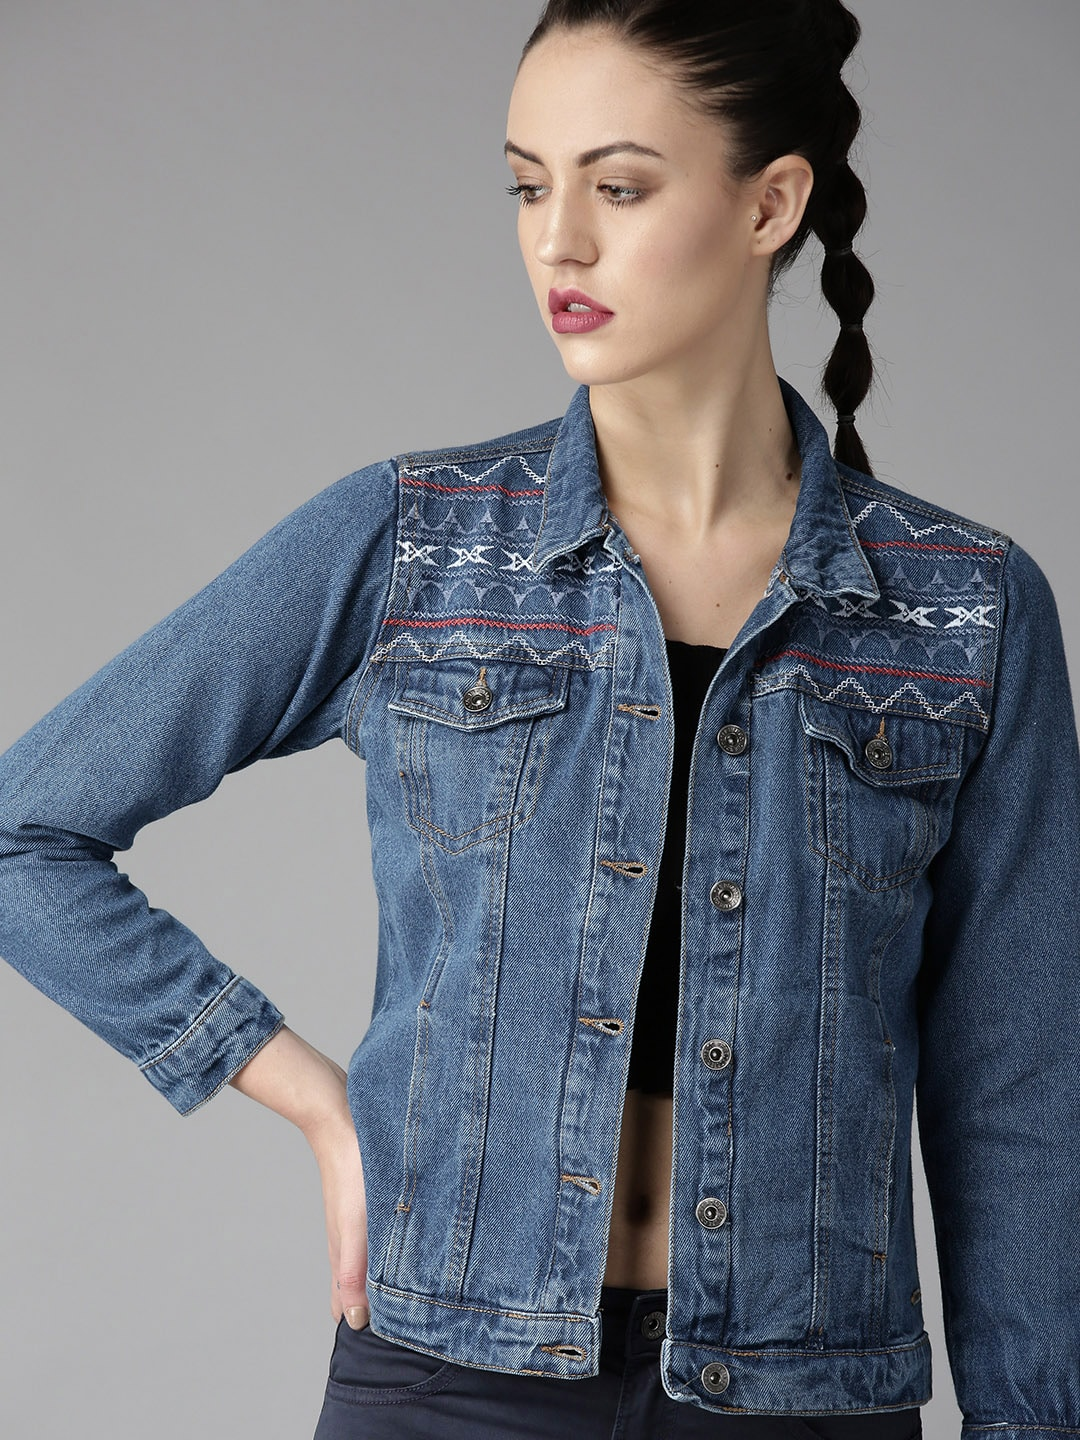


**************************************************
Similar product
**************************************************
The Tokyo Talkies Women White Solid Denim Jacket meets your criteria with 4 pockets, a rating of 4.31, and a price of 2249. It has a spread collar, button closure, three-quarter sleeves, and is machine washable in cotton fabric. A casual piece perfect for a stylish everyday look.

The suggested product looks like 


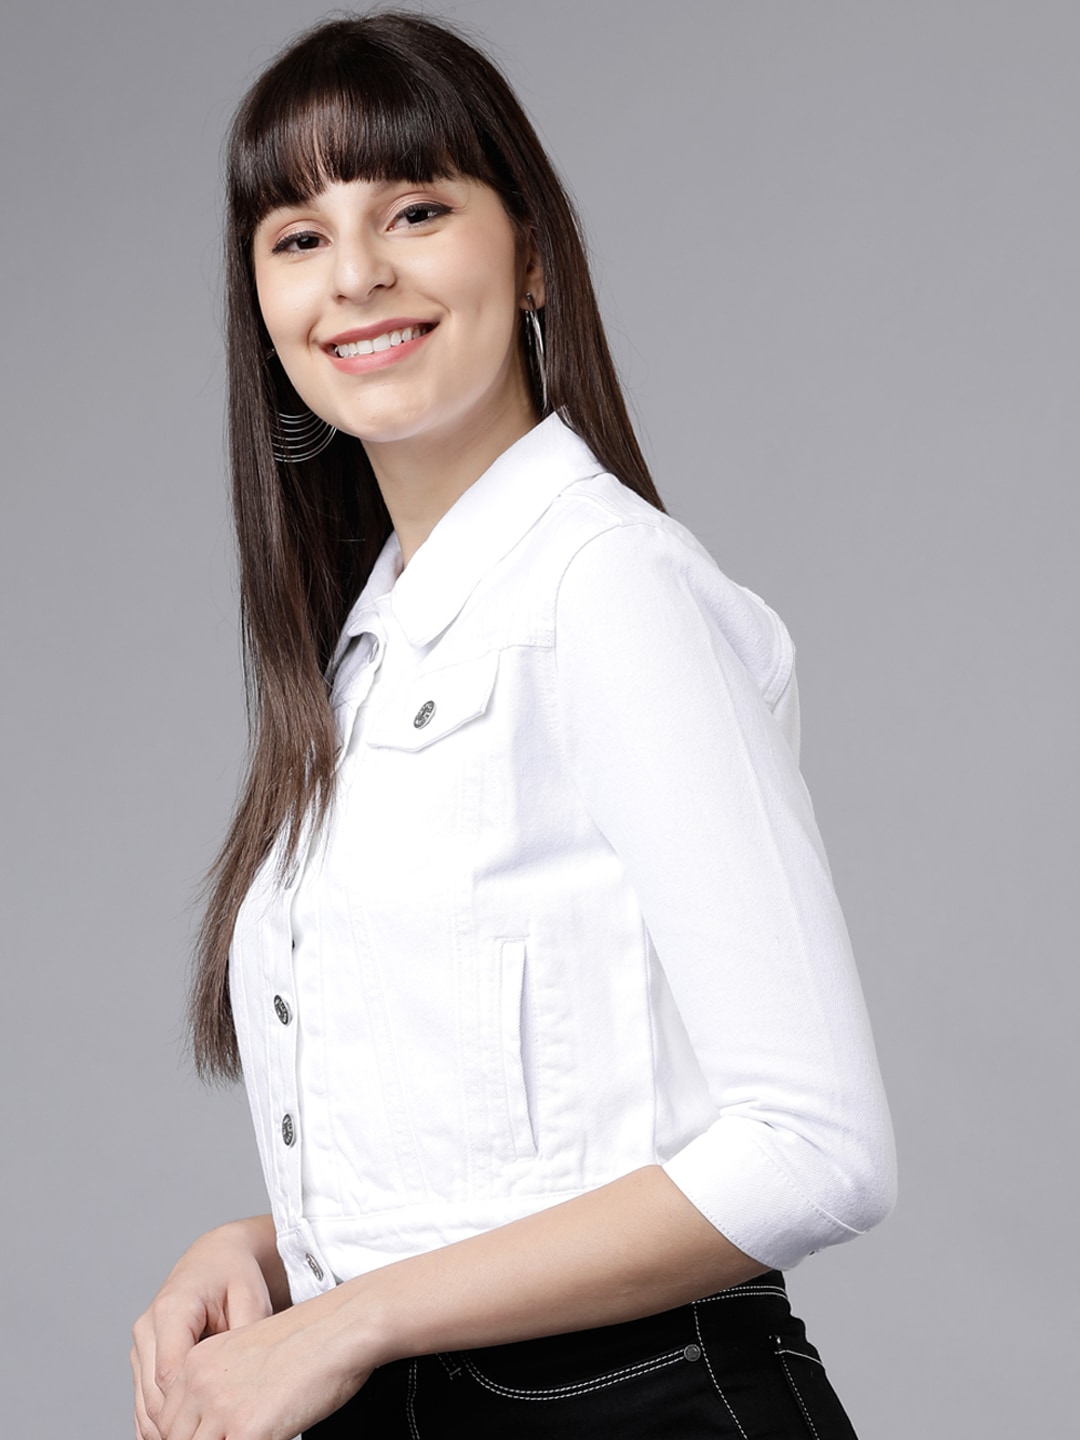


**************************************************
Similar product
**************************************************
The Tokyo Talkies Women Blue Solid Denim Jacket meets your criteria for a denim jacket with at least 4 pockets, a rating of 4, and a price less than 3000. This jacket has 4 pockets, a rating of 4.33, and is priced at 2149. It features a spread collar, button closure, long sleeves, and a straight hem. The fabric is cotton, and it is unlined.


The suggested product looks like 


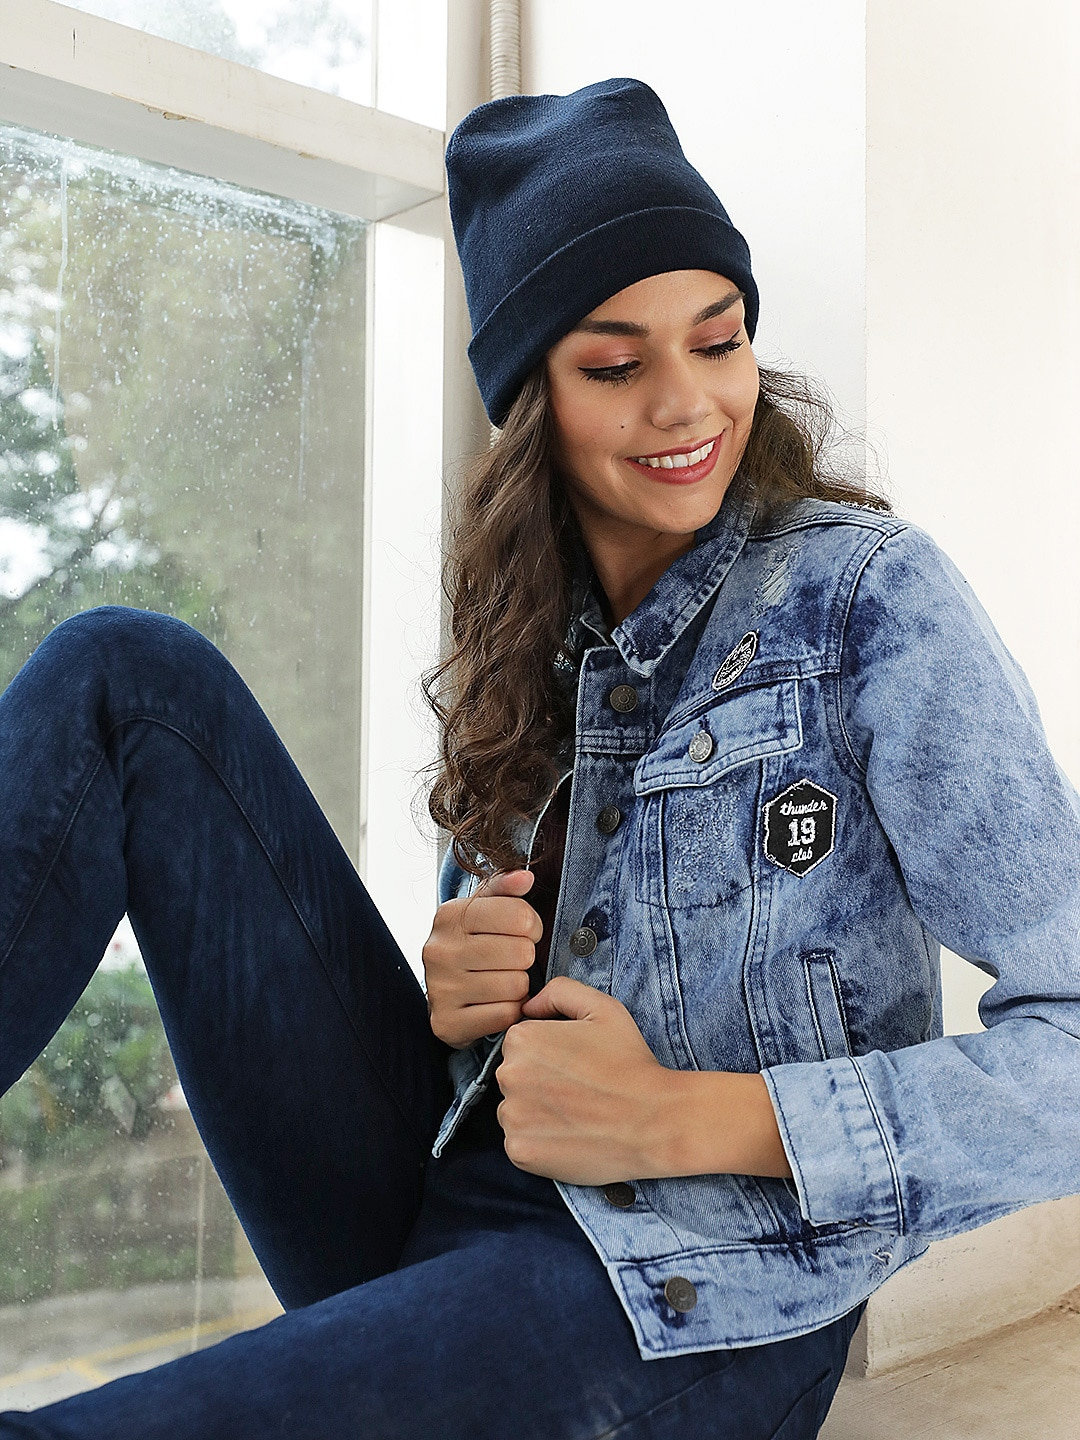

In [87]:
GenerativeSearch("Denim jacket with atleast 4 pockets, a rating of 4 and price less than 3000")

---
---
<a id='playground'></a>
## <p style="color: #ffd700; background-color: #006400;"> Playground </p>

Try Yourself with some queries !

#### Run the below cell to experiment with Semantic Search and Reranking

In [ ]:
SemanticSearchWithReranking()

#### Run the below cell to experiment with Generative Search

In [ ]:
GenerativeSearch()

---
---